
# Adult Census Income Classification

**Objective**  
Predict whether an individual's income exceeds \$50K/year using a **heavily imbalanced** Adult Census dataset with **survey weights** representing population proportions.

**Key Challenges**
- Severe class imbalance  
- Presence of sample weights (must be used consistently)  
- Mixed numerical + categorical features  
- Large feature space after encoding (~300+)



In [ ]:
# Note: Run this cell only if you are reading the input dataset from the drive.
# Else, you can simply upload the files in the Data folder of git into colab and begin
# running the notebook after modifying the paths
from google.colab import drive
drive.mount('/content/drive')


## 1. Imports & Reproducibility


In [1]:
!pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import CatBoostClassifier
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2. Data Loading And Data Overview
Assumes:
- `target` → binary income label  
- `weight` → survey weight  


In [4]:
df = pd.read_csv('/content/sample_data/census-bureau.data', header = None)
columns = pd.read_csv('/content/sample_data/census-bureau.columns', header = None)

df.columns = columns[0].tolist()
print("Shape of the dataframe",df.shape)
df.head(5)

Shape of the dataframe (199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
summary = []
for col in df.columns:
    summary.append({
        "column": col,
        "dtype": df[col].dtype,
        "unique_values": df[col].nunique(),
        "sample_values": df[col].unique()
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

                                        column    dtype  unique_values  \
0                                          age    int64             91   
1                              class of worker   object              9   
2                     detailed industry recode    int64             52   
3                   detailed occupation recode    int64             47   
4                                    education   object             17   
5                                wage per hour    int64           1240   
6                   enroll in edu inst last wk   object              3   
7                                 marital stat   object              7   
8                          major industry code   object             24   
9                        major occupation code   object             15   
10                                        race   object              5   
11                             hispanic origin   object              9   
12                                    

# 3. Exploratory Data Analysis

In [6]:
# -------------------------------
# Identify columns with null values
# -------------------------------

# Columns that contain at least one null value
null_cols = df.columns[df.isnull().any()]
print("Columns with null values:", null_cols)

# Count of null values per column (only where count > 0)
null_counts = df.isnull().sum()
print("\nNumber of null values per column:", null_counts[null_counts > 0])

# -------------------------------
# Observation:  NULL values can be replaced with 'Do not know' value
# -------------------------------


# -------------------------------
# Handle ambiguous value '?'
# -------------------------------

mask = (df == '?').any(axis=1)
count_rows = mask.sum()
print("Count of rows with ? value ",count_rows)

mask = (df == '?') | (df.isnull())
cols_with_missing = df.columns[mask.any(axis=0)]
print("Columns with missing values:", cols_with_missing)

# -------------------------------
# Since more than 50% of the data contains "?", we cannot drop these rows.
# -------------------------------


df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')
df['migration code-change in msa'] = (
    df['migration code-change in msa']
    .replace('?', 'Not identifiable')
)
df = df.replace('?', 'Unknown')


# -------------------------------
# Re-check missing values after cleaning
# -------------------------------


mask = (df == '?').any(axis=1) | df.isna().any(axis=1)
rows_with_missing_spch = df[mask]
print("rows with null values or ? after cleaning:", rows_with_missing_spch.shape)



Columns with null values: Index(['hispanic origin'], dtype='object')

Number of null values per column: hispanic origin    874
dtype: int64
Count of rows with ? value  104393
Columns with missing values: Index(['hispanic origin', 'state of previous residence',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'migration prev res in sunbelt',
       'country of birth father', 'country of birth mother',
       'country of birth self'],
      dtype='object')
rows with null values or ? after cleaning: (0, 42)


In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['year','detailed occupation recode', 'detailed industry recode', 'veterans benefits','own business or self employed', 'label'])
numerical_int_cols = [
    'age',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year'
]
df['label'].replace('- 50000.', 0, inplace = True)
df['label'].replace('50000+.', 1, inplace = True)



/tmp/ipython-input-1959439478.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace('- 50000.', 0, inplace = True)
/tmp/ipython-input-1959439478.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

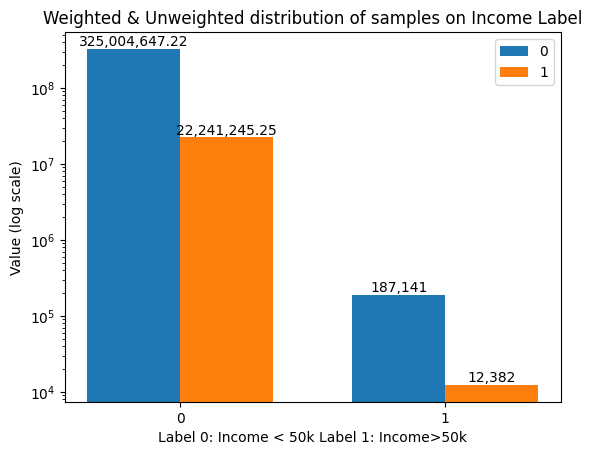

In [13]:
labels = ['0', '1']          # Class labels
x_values = [325004647.22, 187141]      # Bar 1 values for labels 0 and 1
y_values = [22241245.25, 12382 ] # Bar 2 values for labels 0 and 1

# Bar positions
x = np.arange(len(labels))
width = 0.35

# Plot
plt.figure()
plt.bar(x - width/2, x_values, width, label='0')
plt.bar(x + width/2, y_values, width, label='1')

# Log scale
plt.yscale('log')

# Labels and title
plt.xlabel('Label 0: Income < 50k Label 1: Income>50k')
plt.ylabel('Value (log scale)')
plt.title('Weighted & Unweighted distribution of samples on Income Label')
plt.xticks(x, labels)
plt.legend()

# Value labels
for i, v in enumerate(x_values):
    plt.text(i - width/2, v, f'{v:,}', ha='center', va='bottom')
for i, v in enumerate(y_values):
    plt.text(i + width/2, v, f'{v:,}', ha='center', va='bottom')

plt.show()


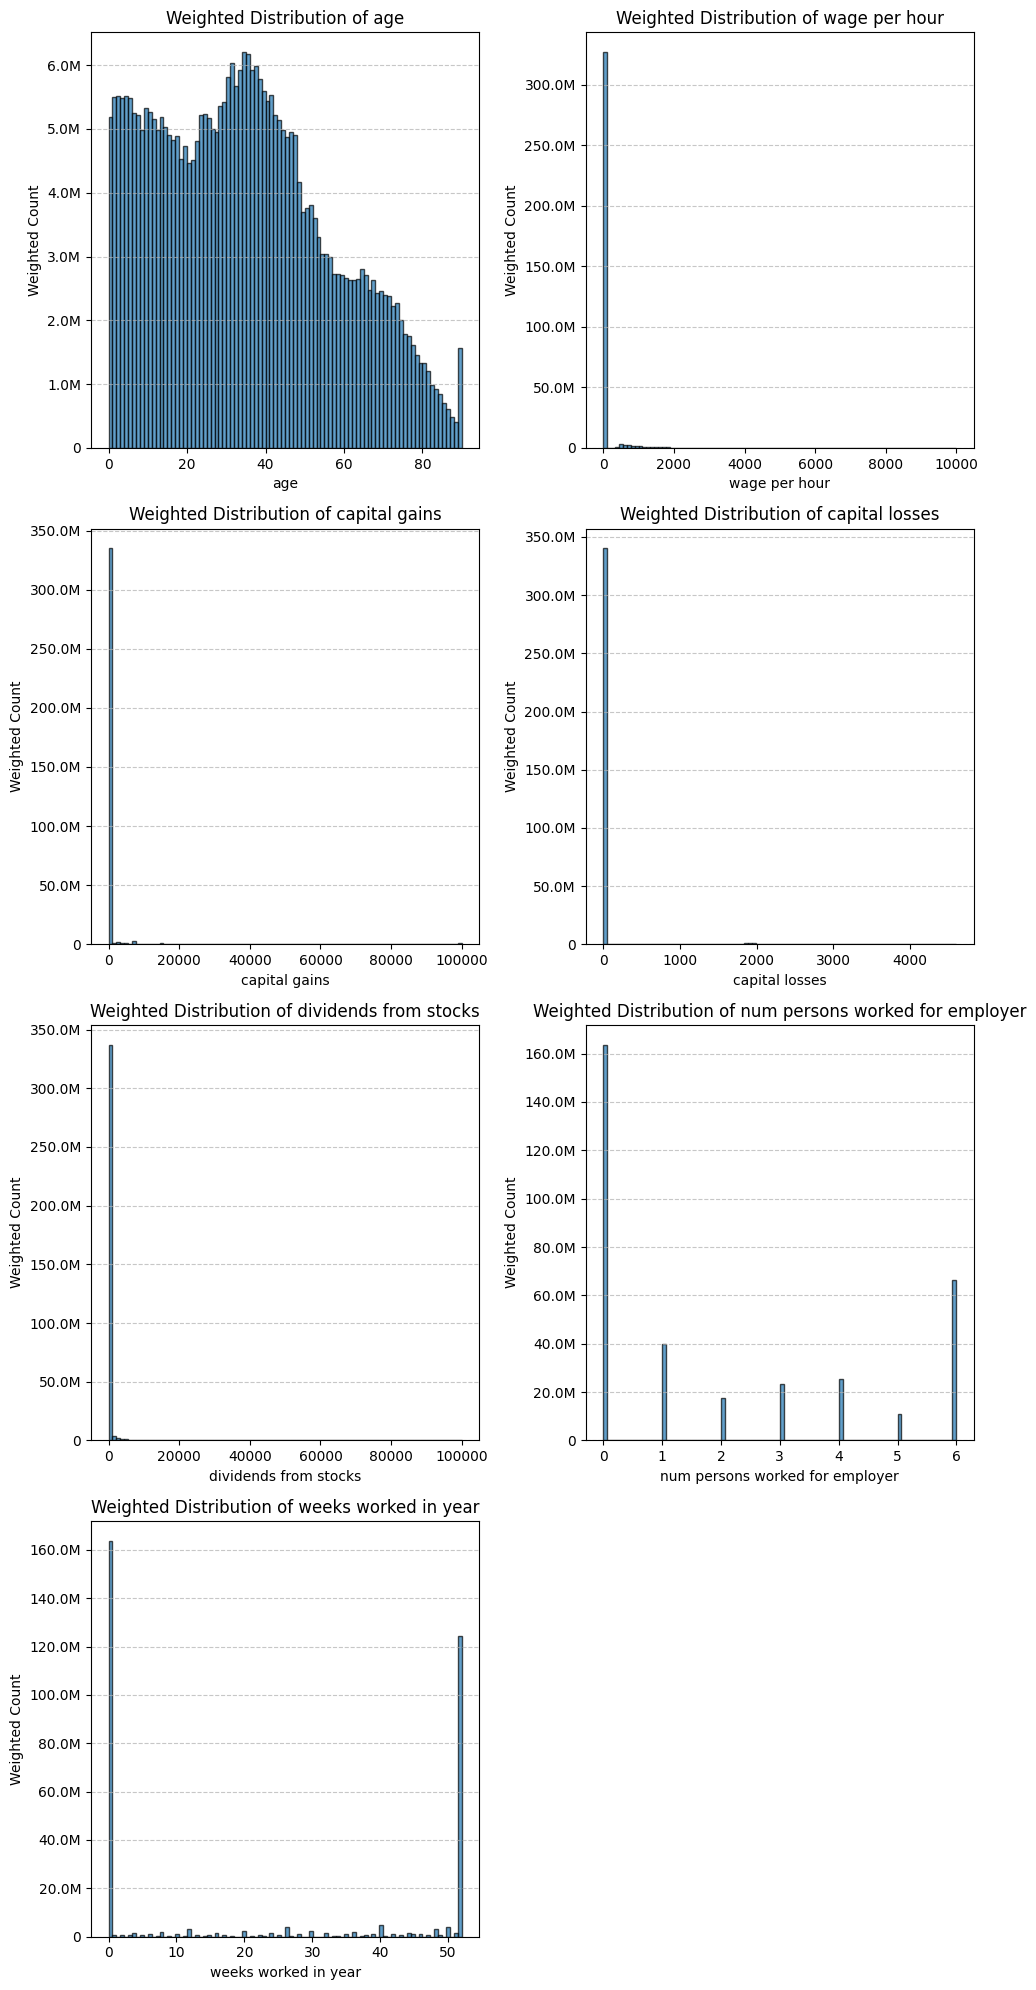

In [8]:
# ✅ CREATE FIGURE AND AXES
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 20)
)

# Ensure axes is iterable
axes = axes.flatten()
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_y_axis(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    else:
        return str(int(x))

# Flatten axes array for easy iteration if there's only one row
if len(numerical_int_cols) == 1:
    axes = [axes]

for i, col in enumerate(numerical_int_cols):
    ax = axes[i]
    # Plot weighted histogram
    ax.hist(df[col], bins=90, weights=df['weight'], edgecolor='black', alpha=0.7)
    ax.set_title(f'Weighted Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Weighted Count')
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(numerical_int_cols), len(axes)):
    fig.delaxes(axes[i]) # Remove the unused subplot



plt.tight_layout()
plt.show()

In [9]:
print("Total Population",df['weight'].sum())
## total population for a city : 347.245 million records
## total age = 0 no of records is 5.18 million
## all aged = 0 had work as Children correctly signifiyig
## 2 records have inconsistent value for 'veteran benefits'
## removing 7 records where children have their marital status as 'Married-civilian spouse present' which doesnot make sense

print("No of samples whose age is Zero",df.loc[df['age'] == 0]['weight'].count()) #2839
print("Population whose age is zero",df.loc[df['age'] == 0]['weight'].sum()) # 5.18 million records
print("Education of samples whose age is zero",df.loc[df['age'] == 0]['education'].value_counts()) #observed only Children distinct value
print("Veteran Benefits of samples whose age is zero",df.loc[df['age'] == 0]['veterans benefits'].value_counts()) # 2 inconsistent records but choose to ignore
print("Emp status of samples whose age is zero",df.loc[df['age'] == 0]['full or part time employment stat'].value_counts()) # all records have Children value
print("Class of worker of samples whose age is zero",df.loc[df['age'] == 0]['class of worker'].value_counts()) # Not in Universe indicative of not applicable to work
condition = (
    (df['age'] < 18) &
    (df['education'] == 'Children') &
    (df['marital stat'] == 'Married-civilian spouse present')
)
print("record_count",df.loc[(df['age'] < 18) & (df['education'] == 'Children') & (df['marital stat']=='Married-civilian spouse present')]['weight'].sum())

# Planning to remove : weighted 131514 record because it doesnot make sense for a child to be married.
# remove 7 records who are children and have marital status
df_filtered = df.loc[~condition].reset_index(drop=True)


## Applying log on columns that have left/right skewed distribution
skewed_cols = [ 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks','weeks worked in year']
for col in skewed_cols:
    df_filtered[col] = np.log1p(df_filtered[col])


Total Population 347245892.46999997
No of samples whose age is Zero 2839
Population whose age is zero 5187670.5600000005
Education of samples whose age is zero education
Children    2839
Name: count, dtype: int64
Veteran Benefits of samples whose age is zero veterans benefits
0    2837
2       2
Name: count, dtype: int64
Emp status of samples whose age is zero full or part time employment stat
Children or Armed Forces    2839
Name: count, dtype: int64
Class of worker of samples whose age is zero class of worker
Not in universe    2839
Name: count, dtype: int64
record_count 13917.08


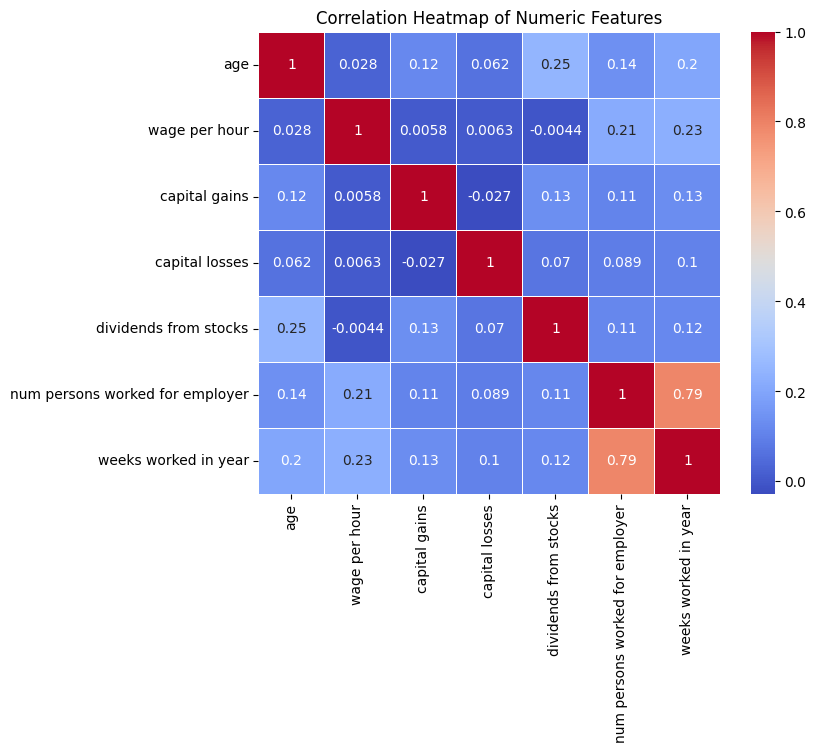

In [10]:
#Correlation Heatmap of Numeric Features
corr = df_filtered[numerical_int_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    square=True
)

plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# observed two numerical features are highly correlated no of weeks worked and no of employers under

/tmp/ipython-input-285915021.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered.groupby("education").apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-285915021.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered.groupby("education").apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum

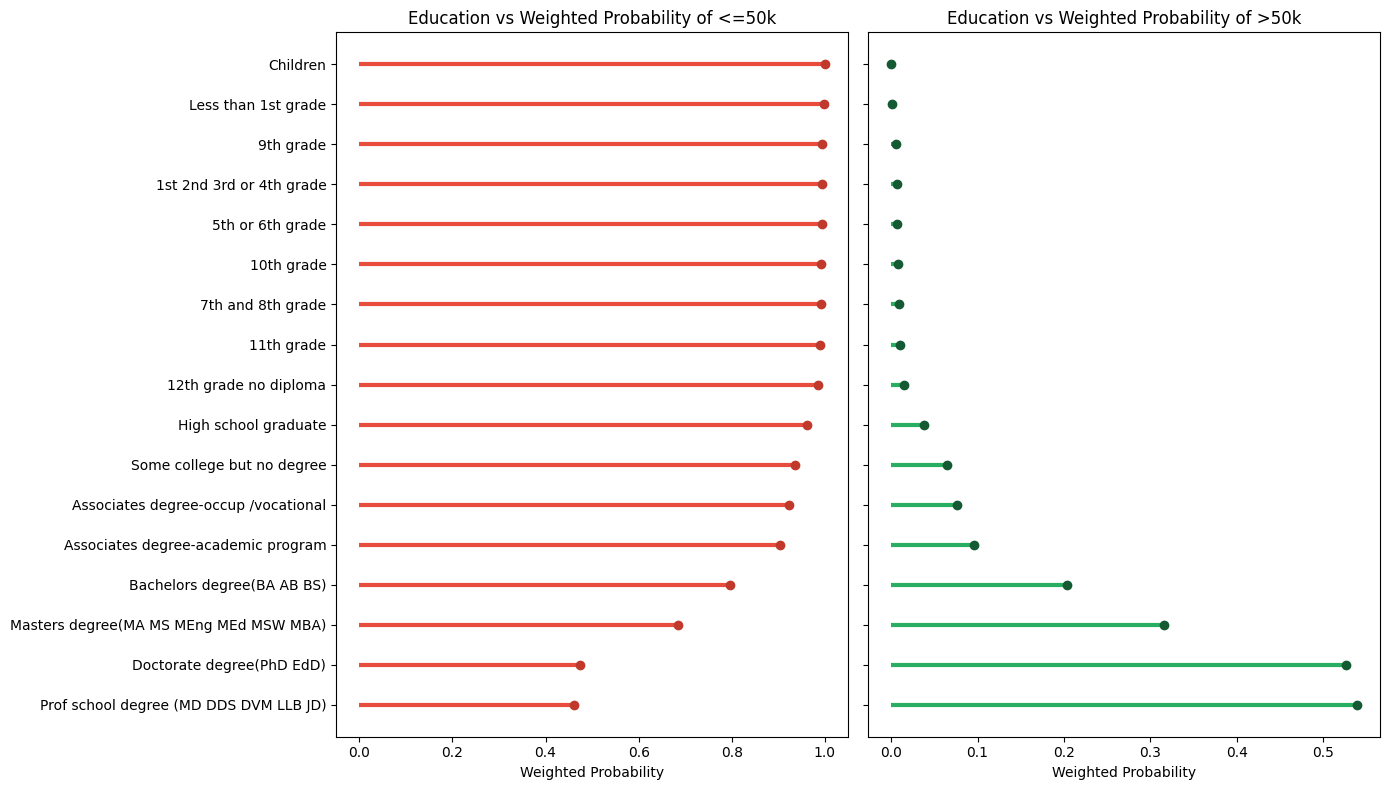

In [11]:

# Calculate weighted probability of <50k for each education group
edu_low_income = (
    df_filtered.groupby("education").apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
    .sort_values()
)

# Calculate weighted probability of >50k for each education group
edu_high_income = (
    df_filtered.groupby("education").apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())
    .sort_values()
)

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14,8), sharey=True)

# <50k
axes[0].hlines(
    y=edu_low_income.index,
    xmin=0,
    xmax=edu_low_income.values,
    color="#e74c3c",
    linewidth=3
)
axes[0].plot(
    edu_low_income.values,
    edu_low_income.index,
    "o",
    color="#c0392b"
)
axes[0].set_title("Education vs Weighted Probability of <=50k")
axes[0].set_xlabel("Weighted Probability")

# >50k
axes[1].hlines(
    y=edu_high_income.index,
    xmin=0,
    xmax=edu_high_income.values,
    color="#27ae60",
    linewidth=3
)
axes[1].plot(
    edu_high_income.values,
    edu_high_income.index,
    "o",
    color="#145a32"
)
axes[1].set_title("Education vs Weighted Probability of >50k")
axes[1].set_xlabel("Weighted Probability")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1285207141.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 1)).sum() / x['weight'].sum())
/tmp/ipython-input-1285207141.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 0)).sum() / x['weight'].sum())


[0.96453896 0.9239492  0.97510535 0.97304127 0.92955556] VALUES


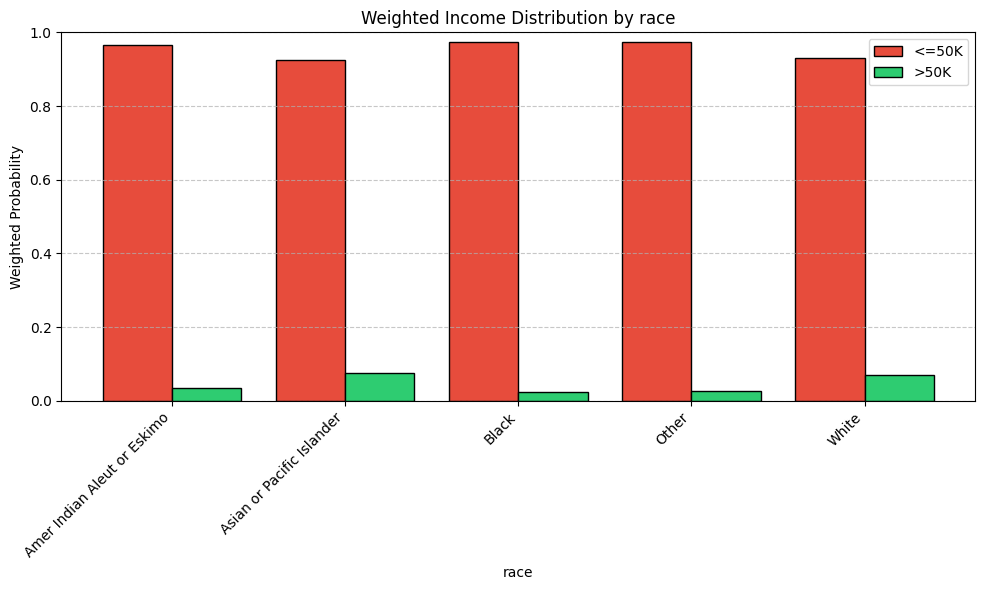

/tmp/ipython-input-1285207141.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 1)).sum() / x['weight'].sum())
/tmp/ipython-input-1285207141.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 0)).sum() / x['weight'].sum())


[0.93067154 0.98194149 0.97484944 0.94919371 0.9395482  0.99005387
 0.97987427 0.96811817 0.97961784] VALUES


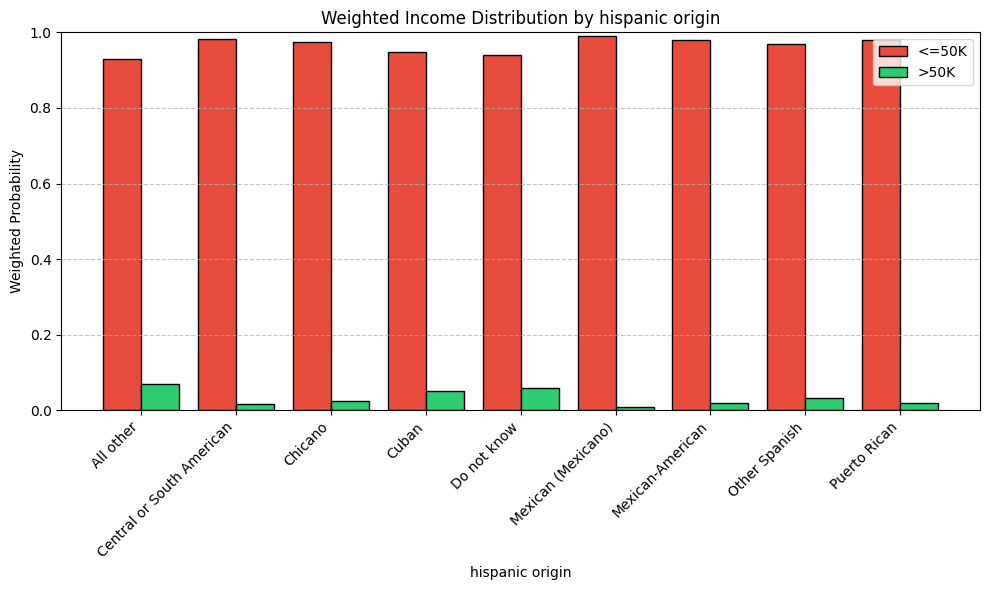

/tmp/ipython-input-1285207141.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 1)).sum() / x['weight'].sum())
/tmp/ipython-input-1285207141.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 0)).sum() / x['weight'].sum())


[0.97327794 0.89677346] VALUES


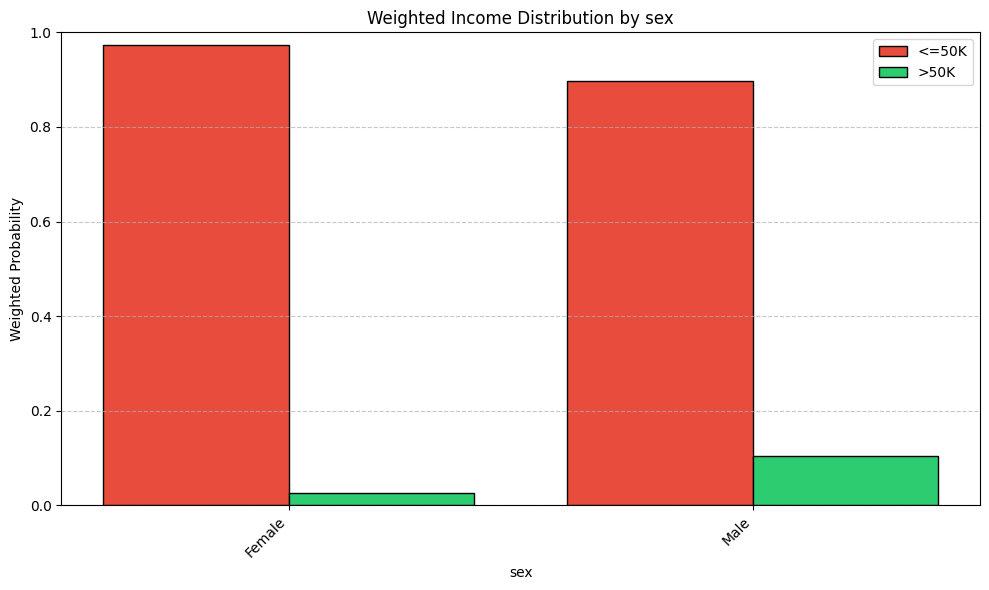

In [12]:
demographic_cols = ['race', 'hispanic origin', 'sex']

for col in demographic_cols:
    grouped = df_filtered.groupby(col)

    # Weighted probabilities
    high_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 1)).sum() / x['weight'].sum())
    low_income = grouped.apply(lambda x: (x['weight'] * (x['label'] == 0)).sum() / x['weight'].sum())
    print(low_income.unique(),"VALUES")
    # Create positions for side-by-side bars
    categories = high_income.index
    x = np.arange(len(categories))
    width = 0.4  # bar width

    fig, ax = plt.subplots(figsize=(10,6))

    ax.bar(x - width/2, low_income.values, width, label='<=50K', color='#e74c3c', edgecolor='black')
    ax.bar(x + width/2, high_income.values, width, label='>50K', color='#2ecc71', edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylabel('Weighted Probability')
    ax.set_xlabel(col)
    ax.set_title(f'Weighted Income Distribution by {col}')
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


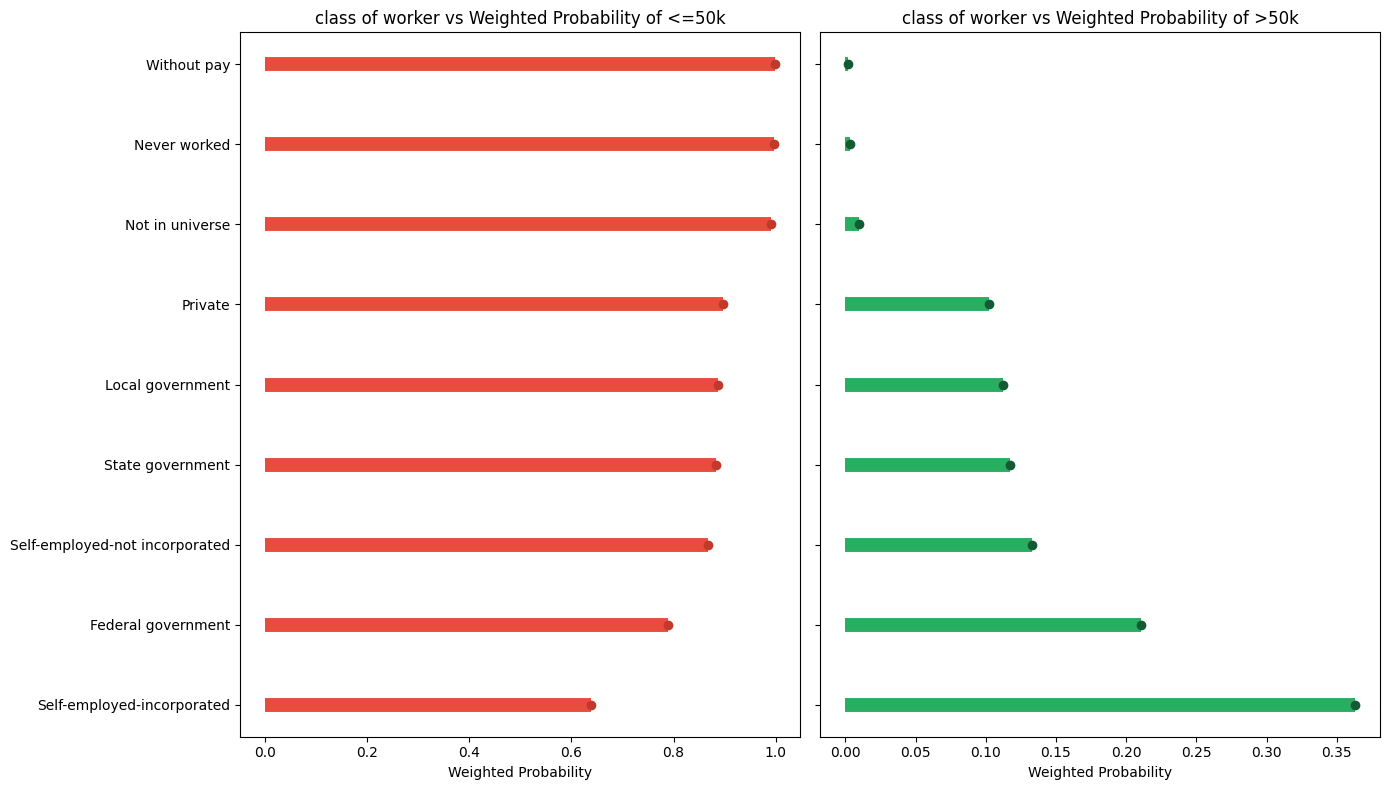

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


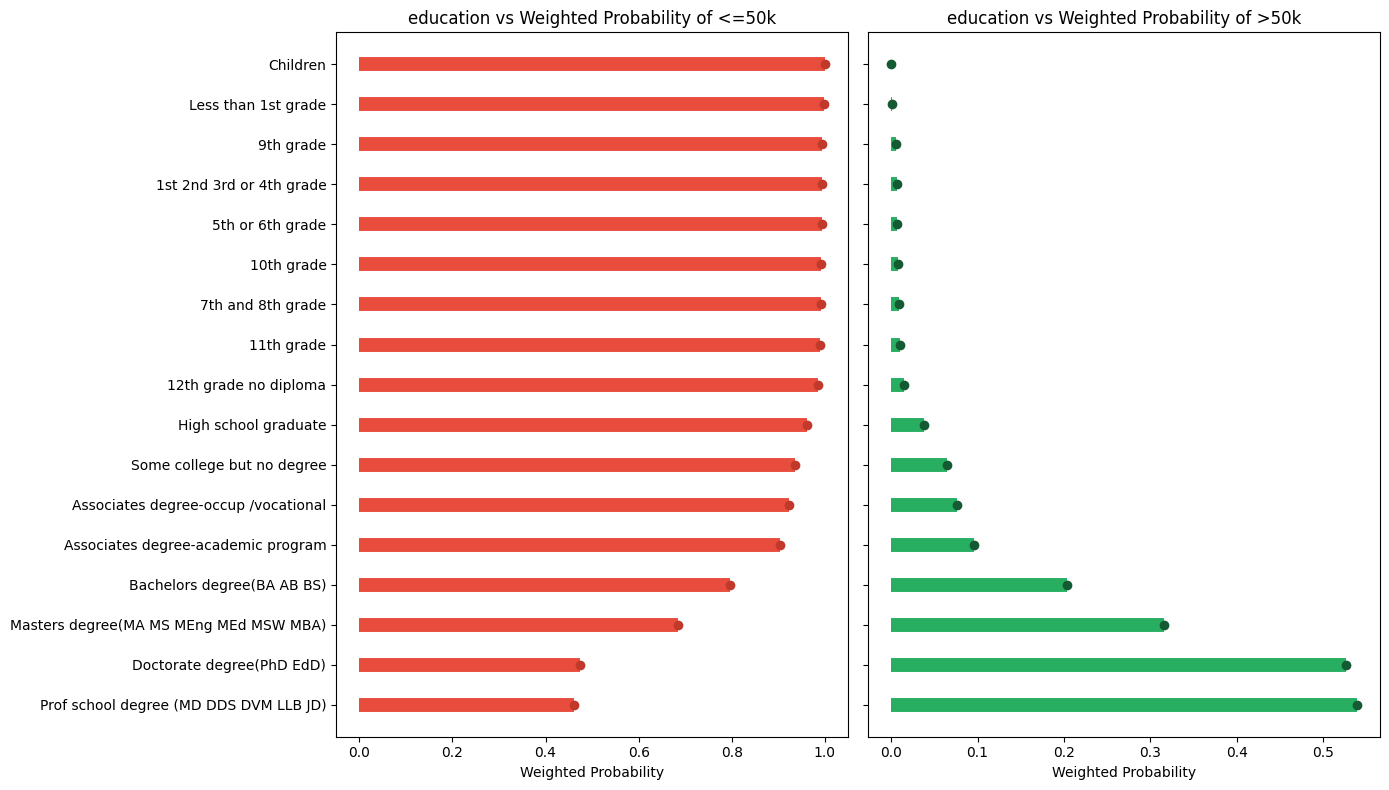

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


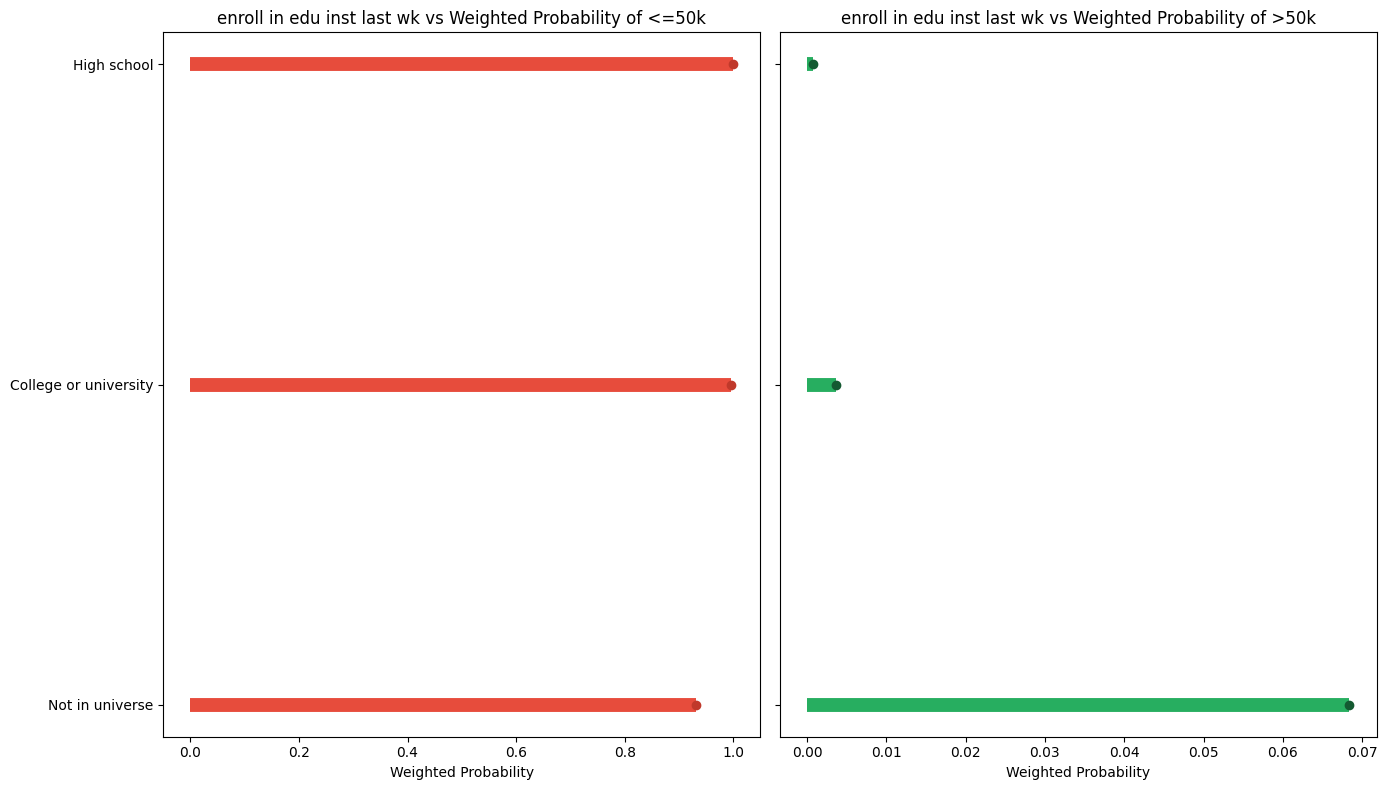

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


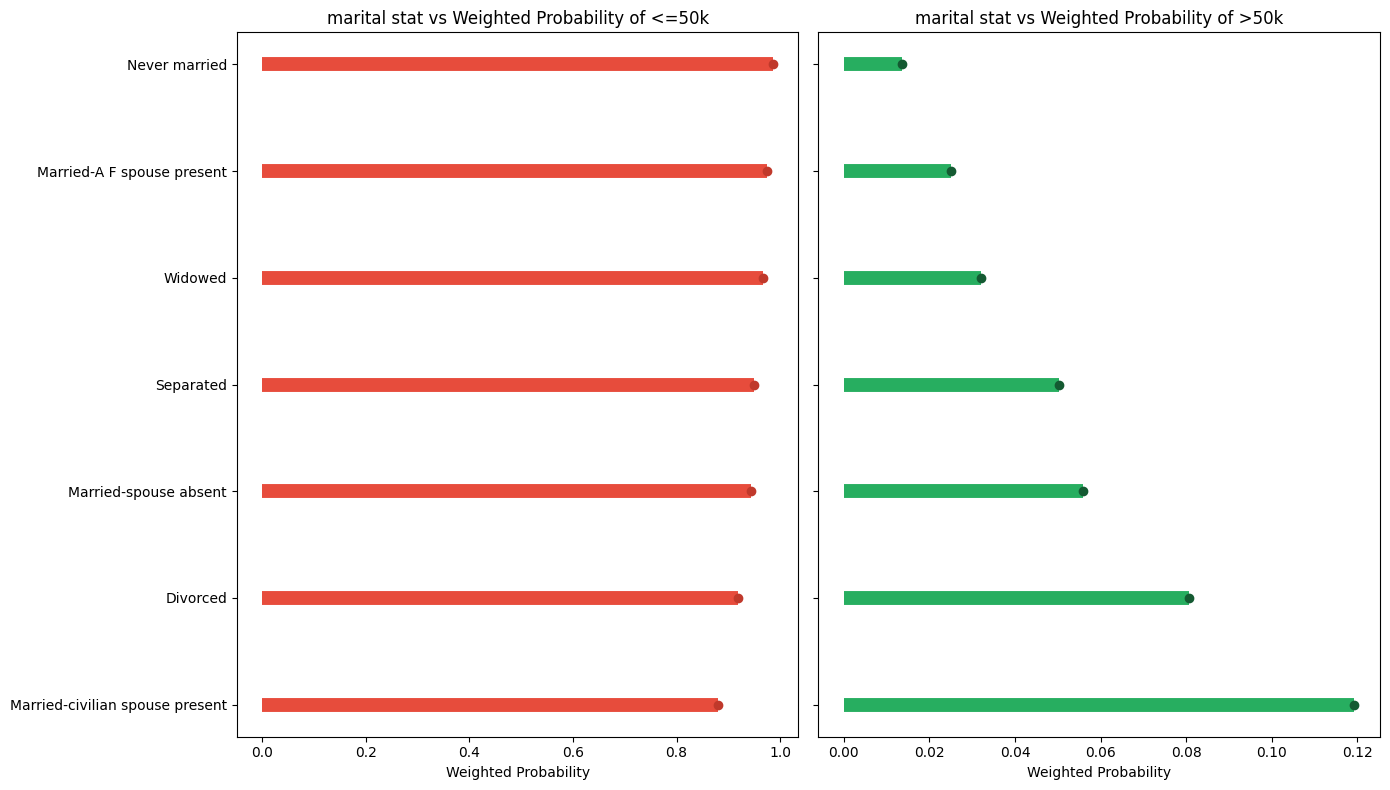

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


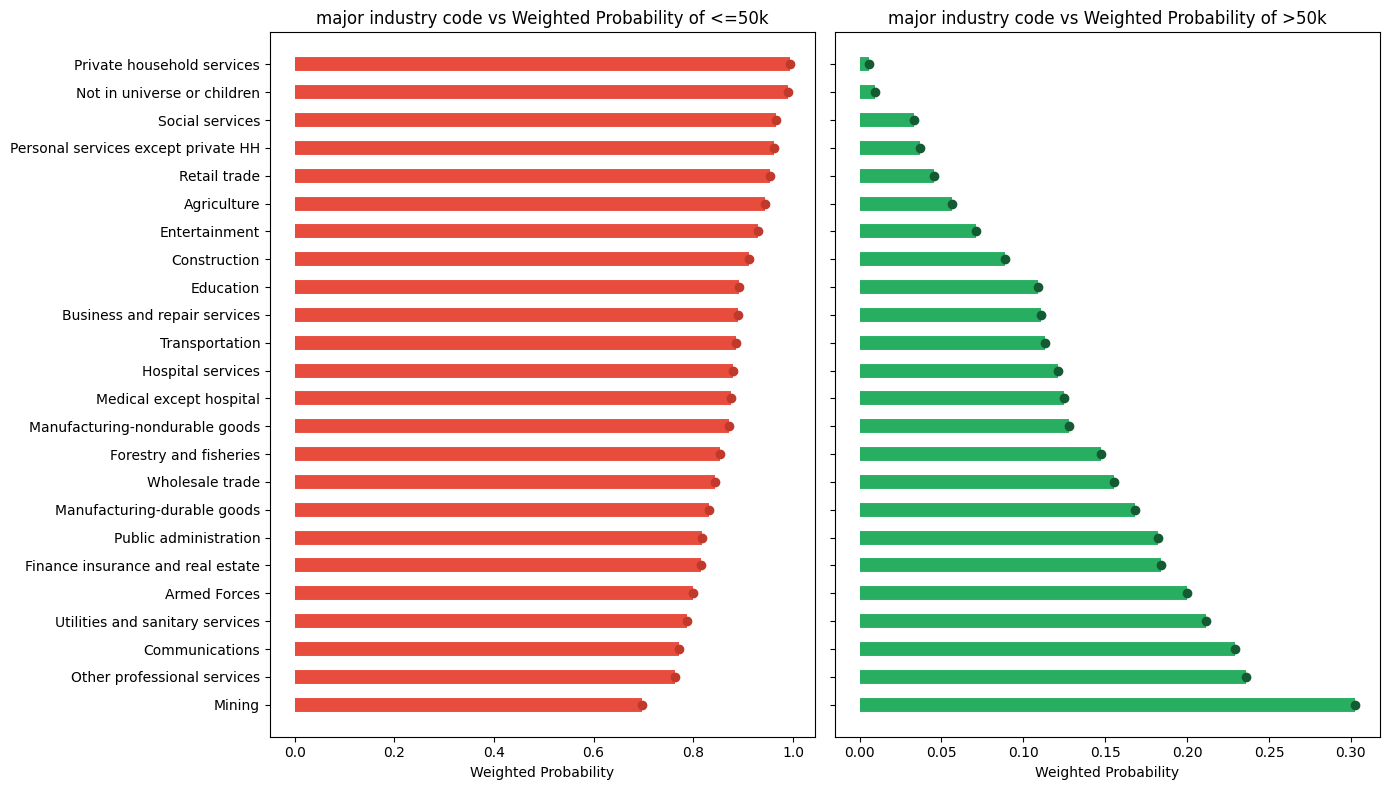

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


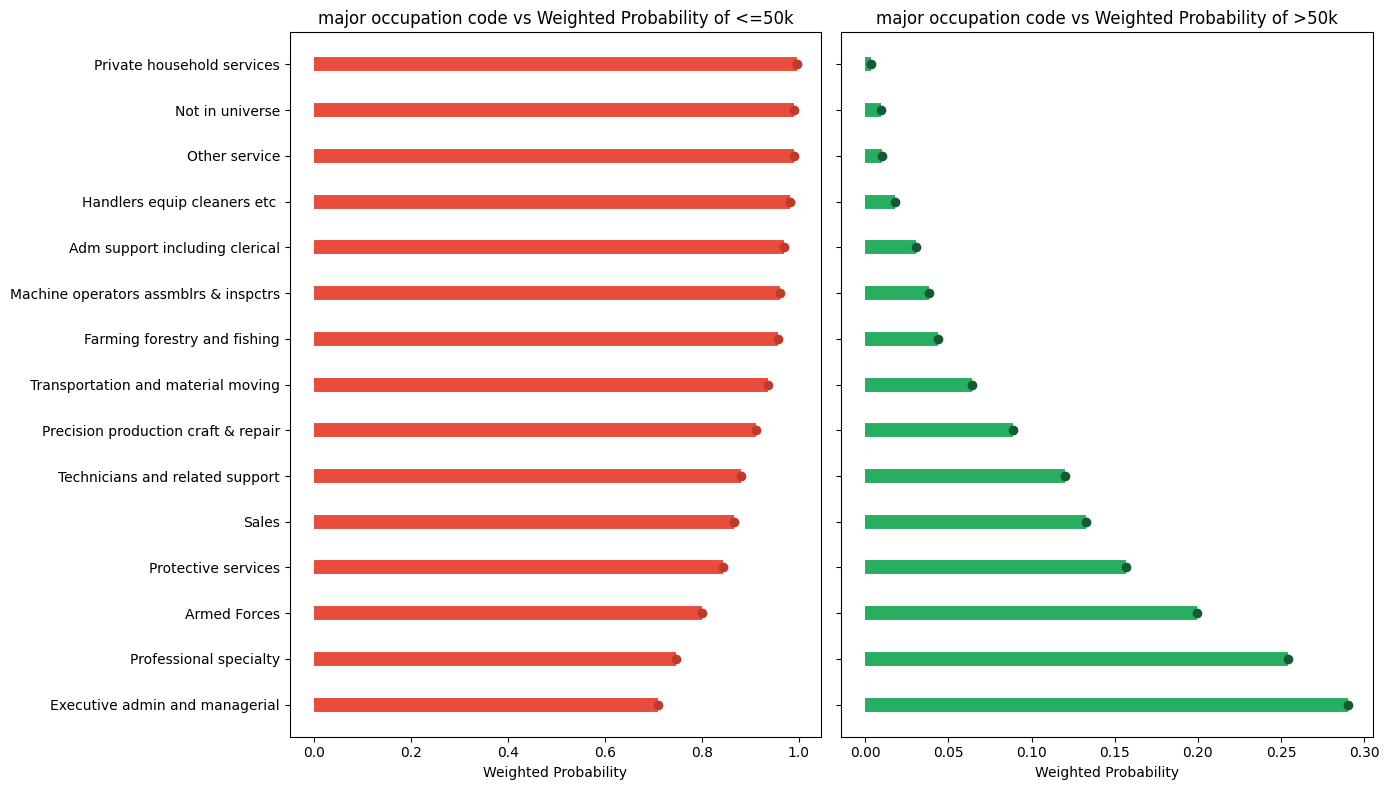

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


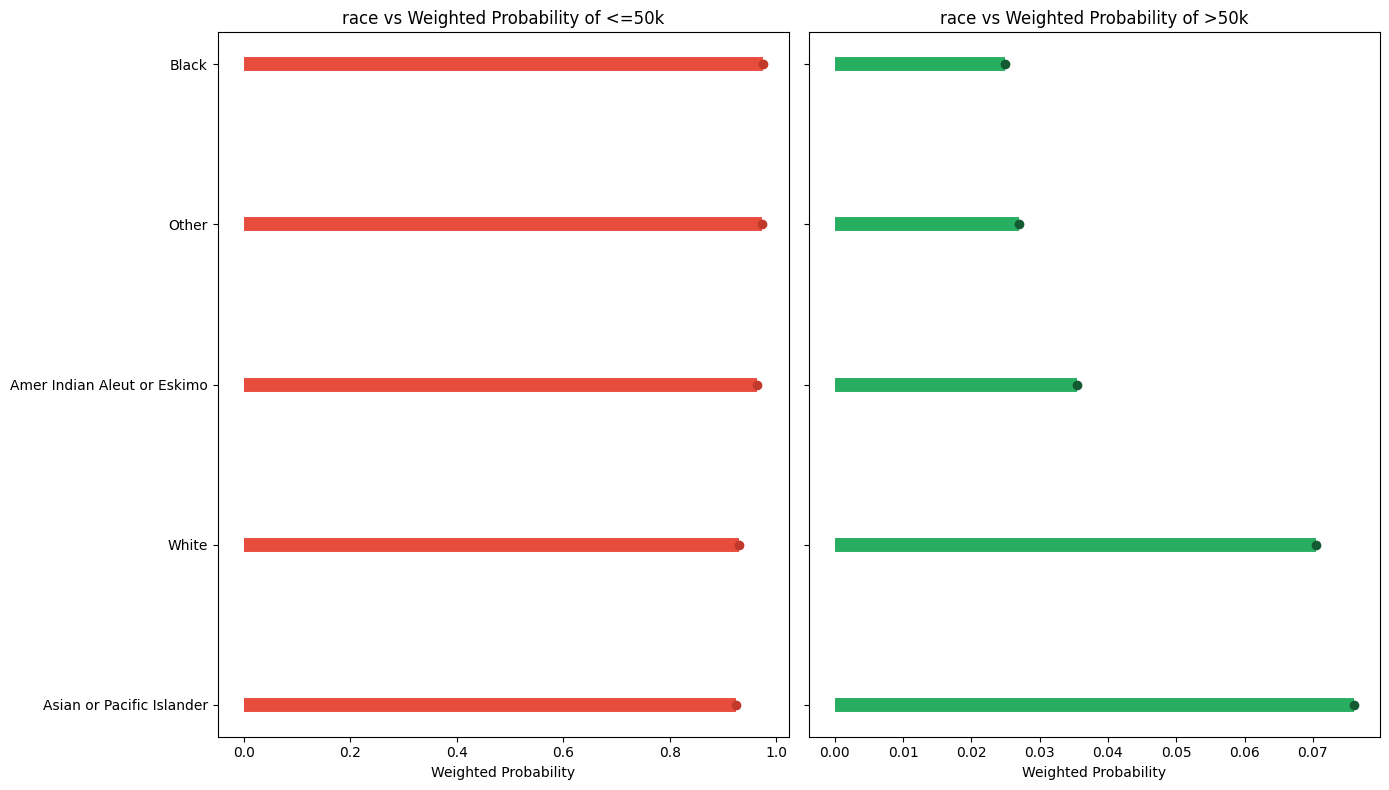

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


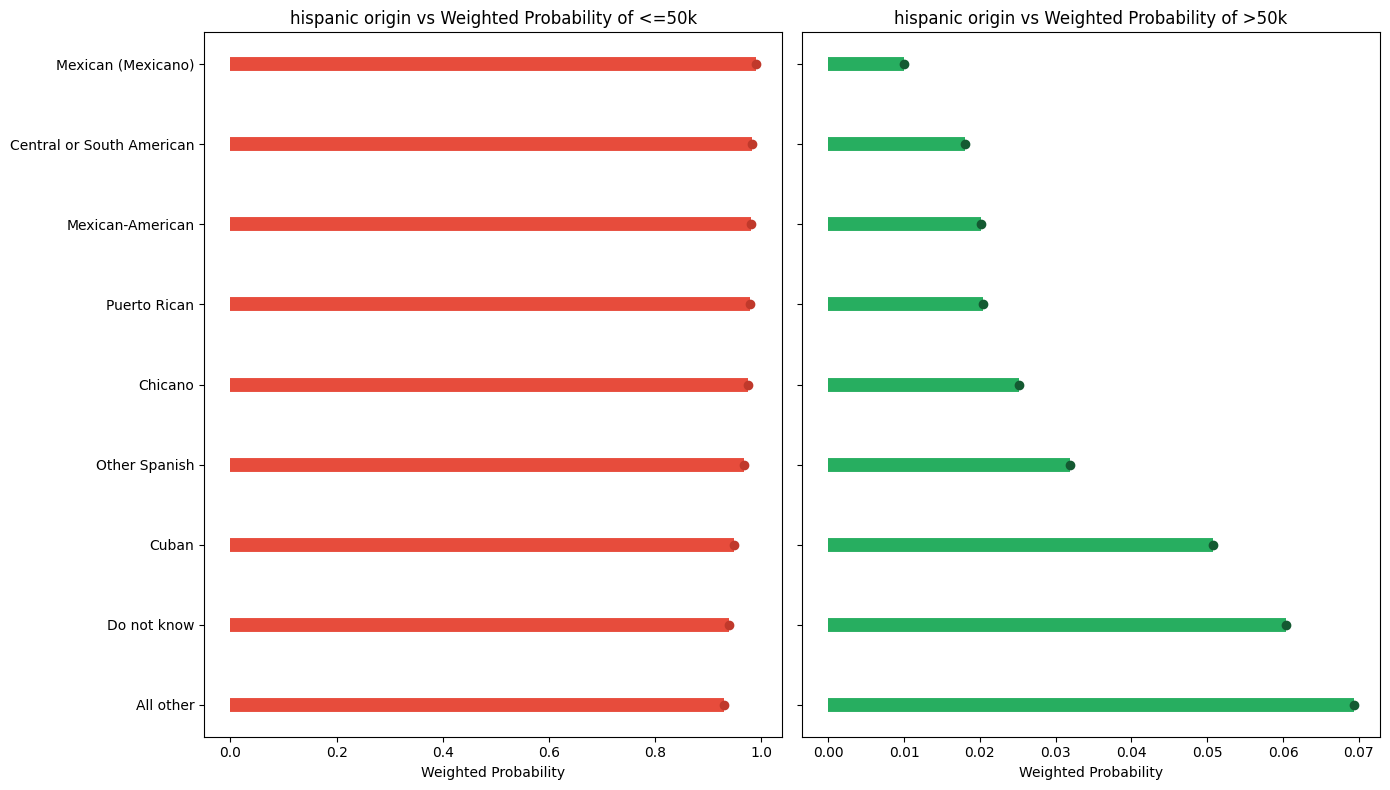

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


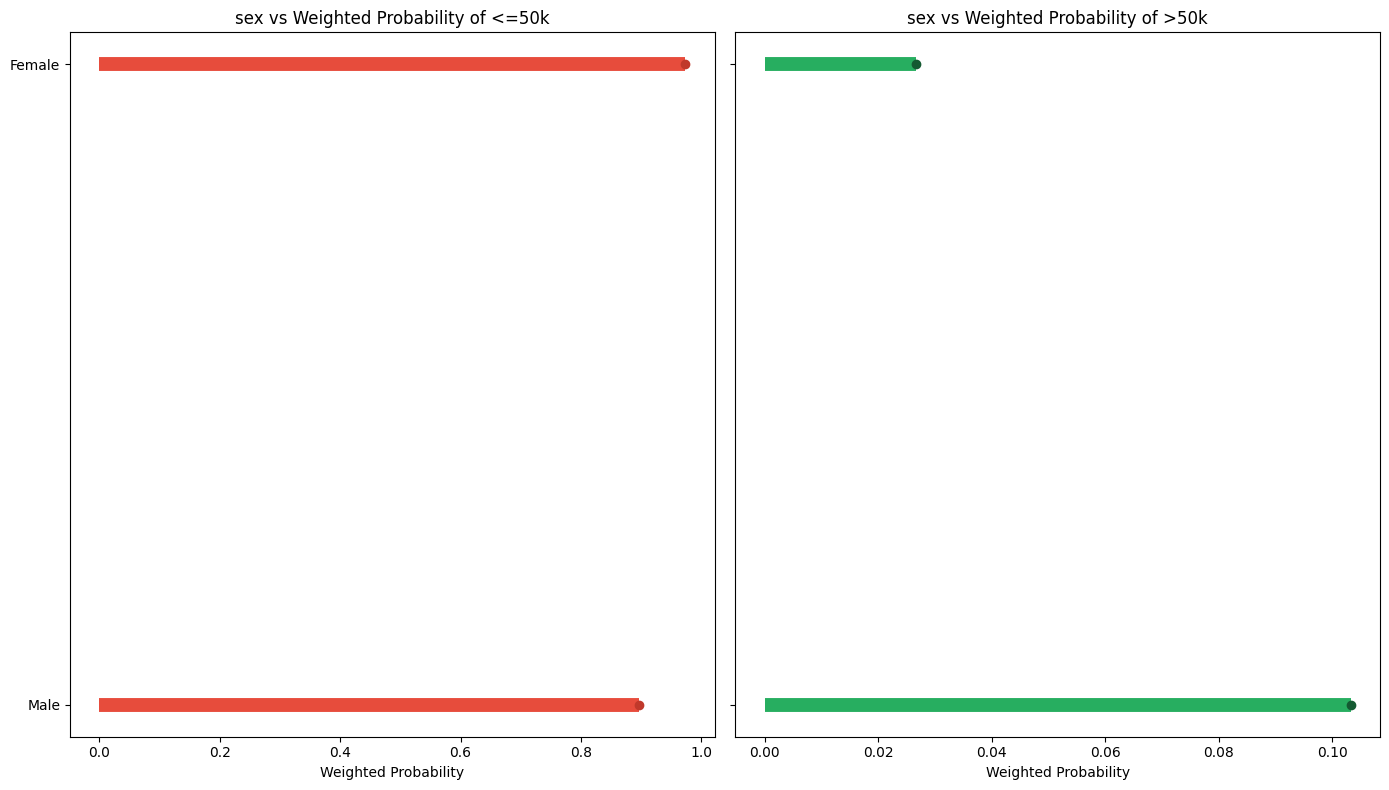

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


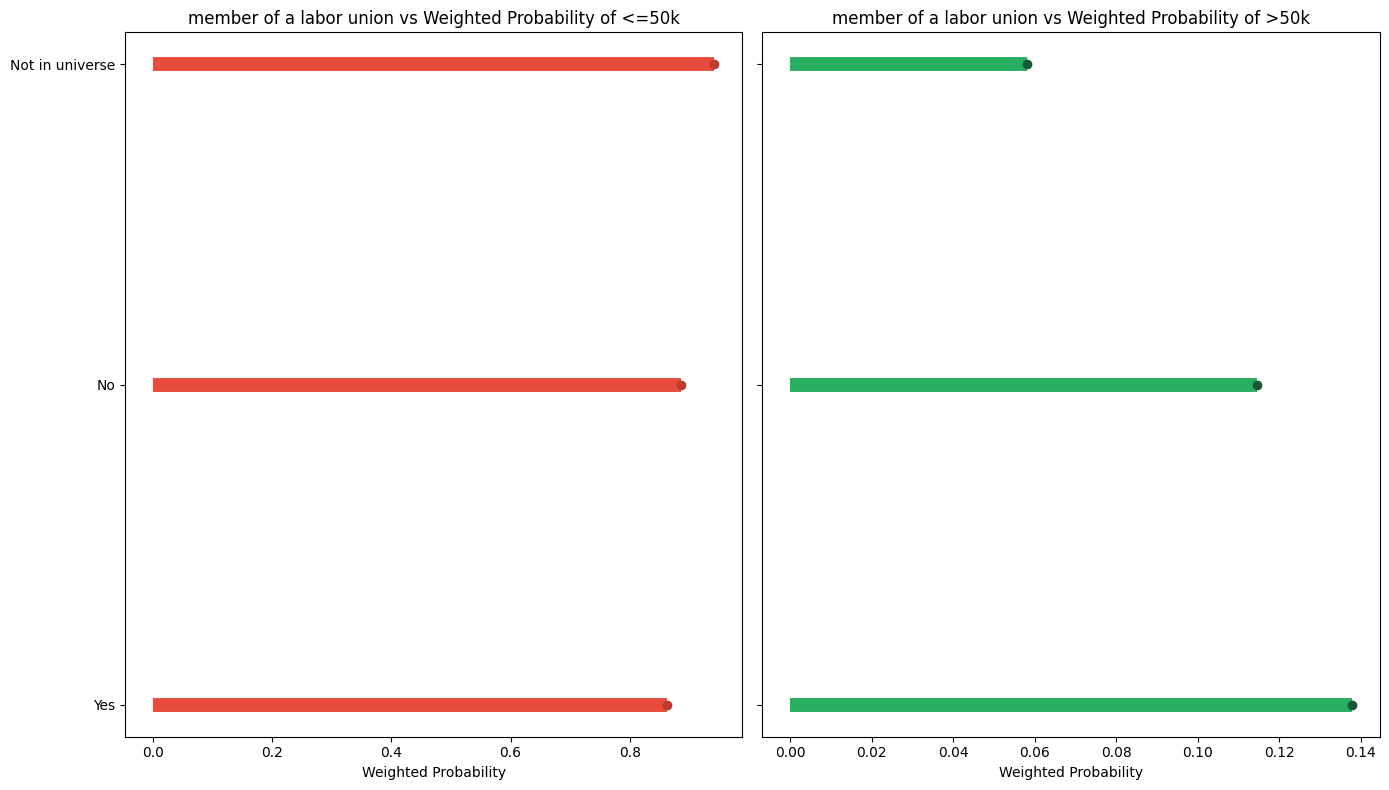

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


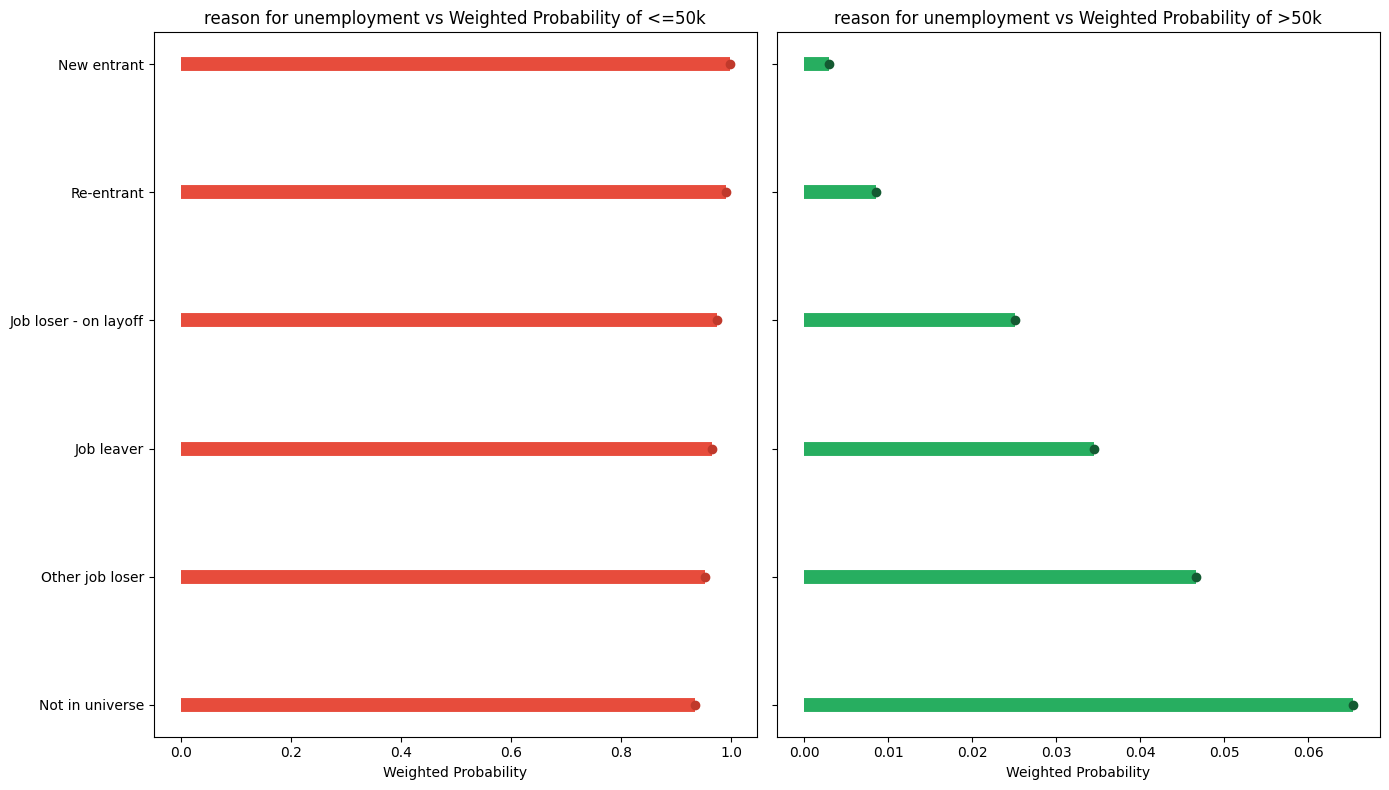

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


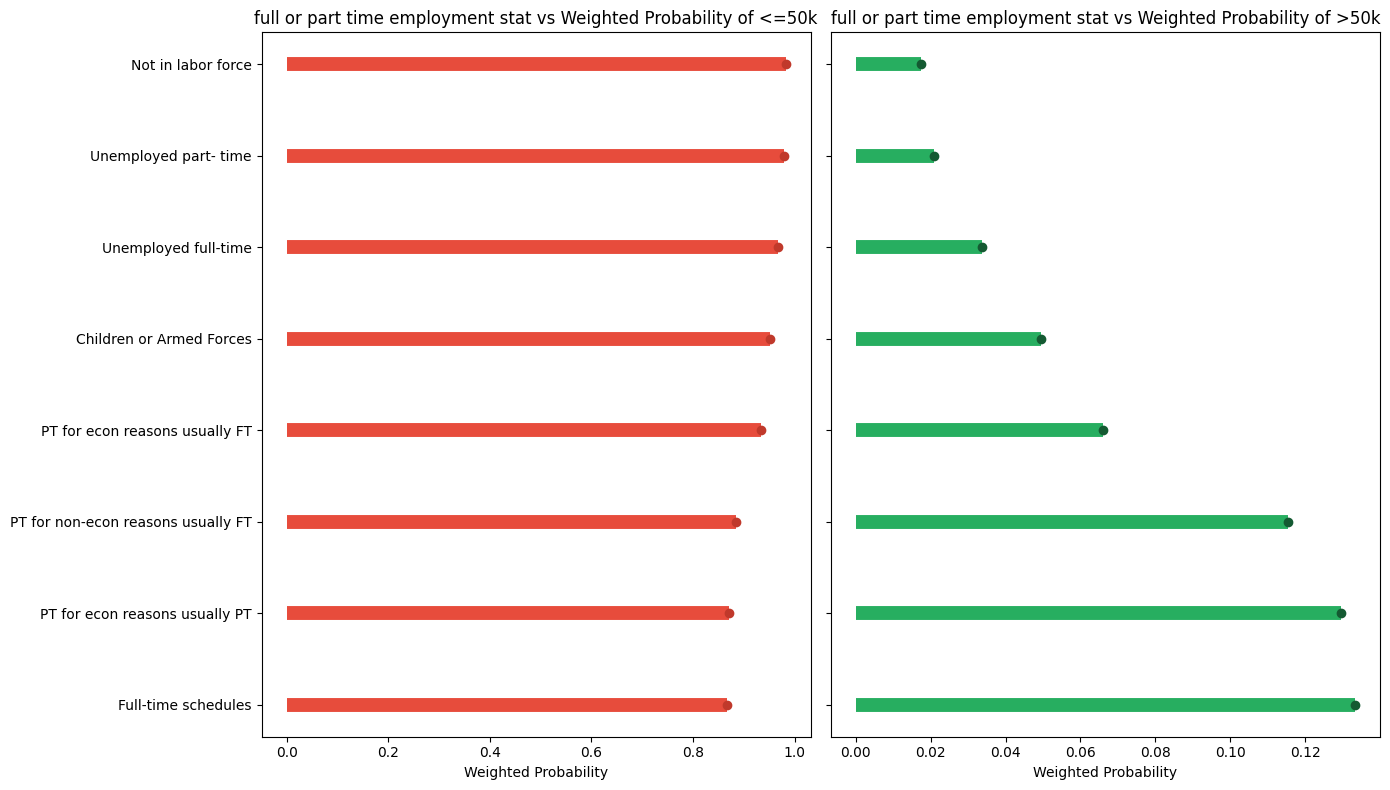

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


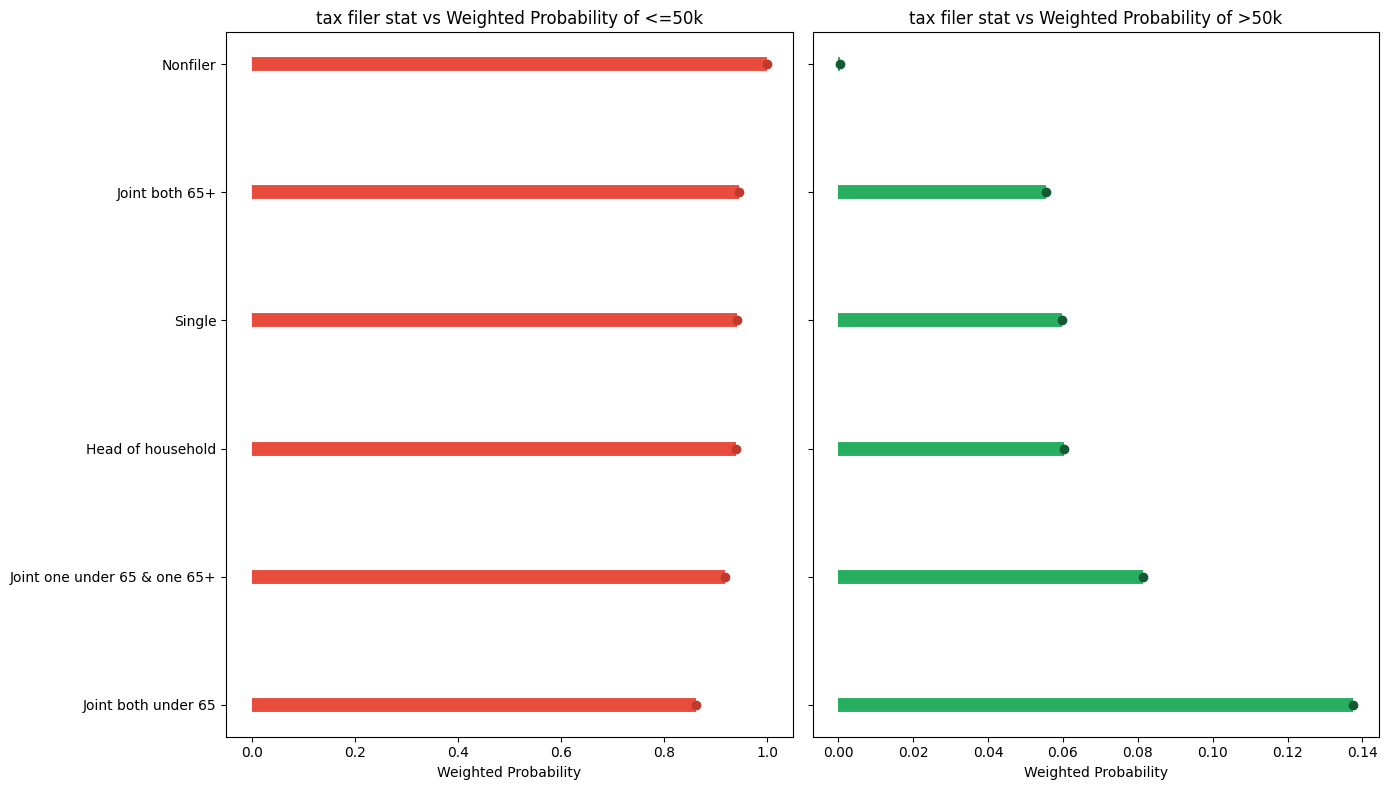

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


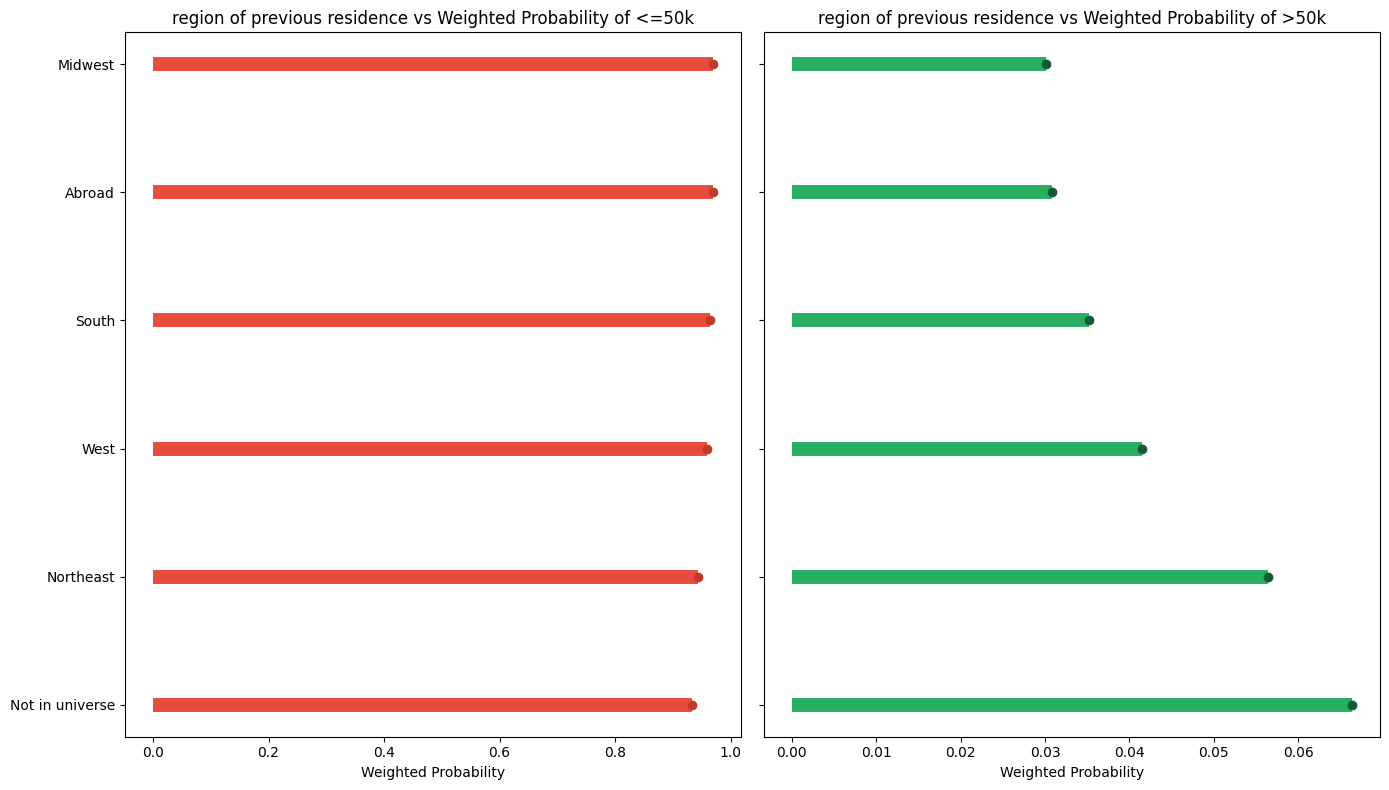

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


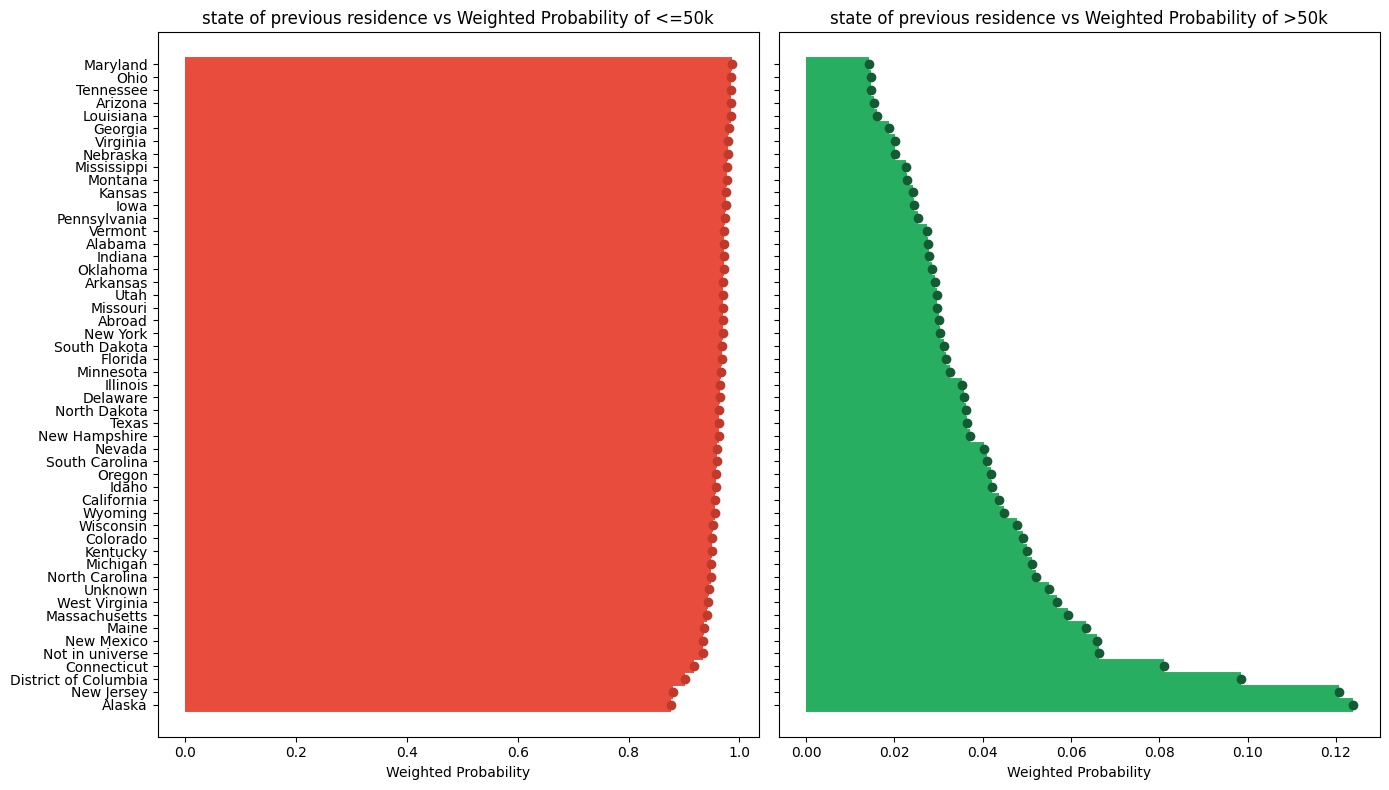

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


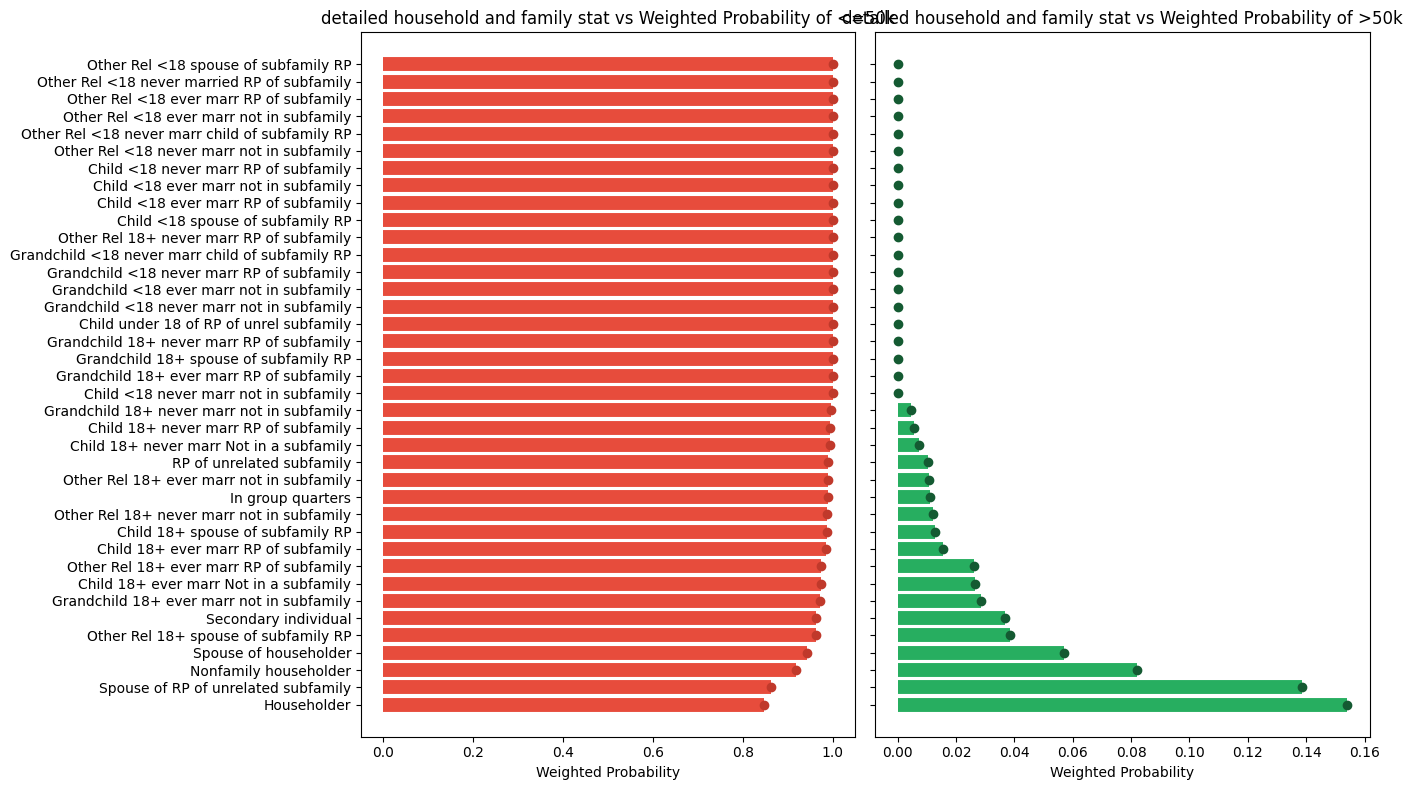

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


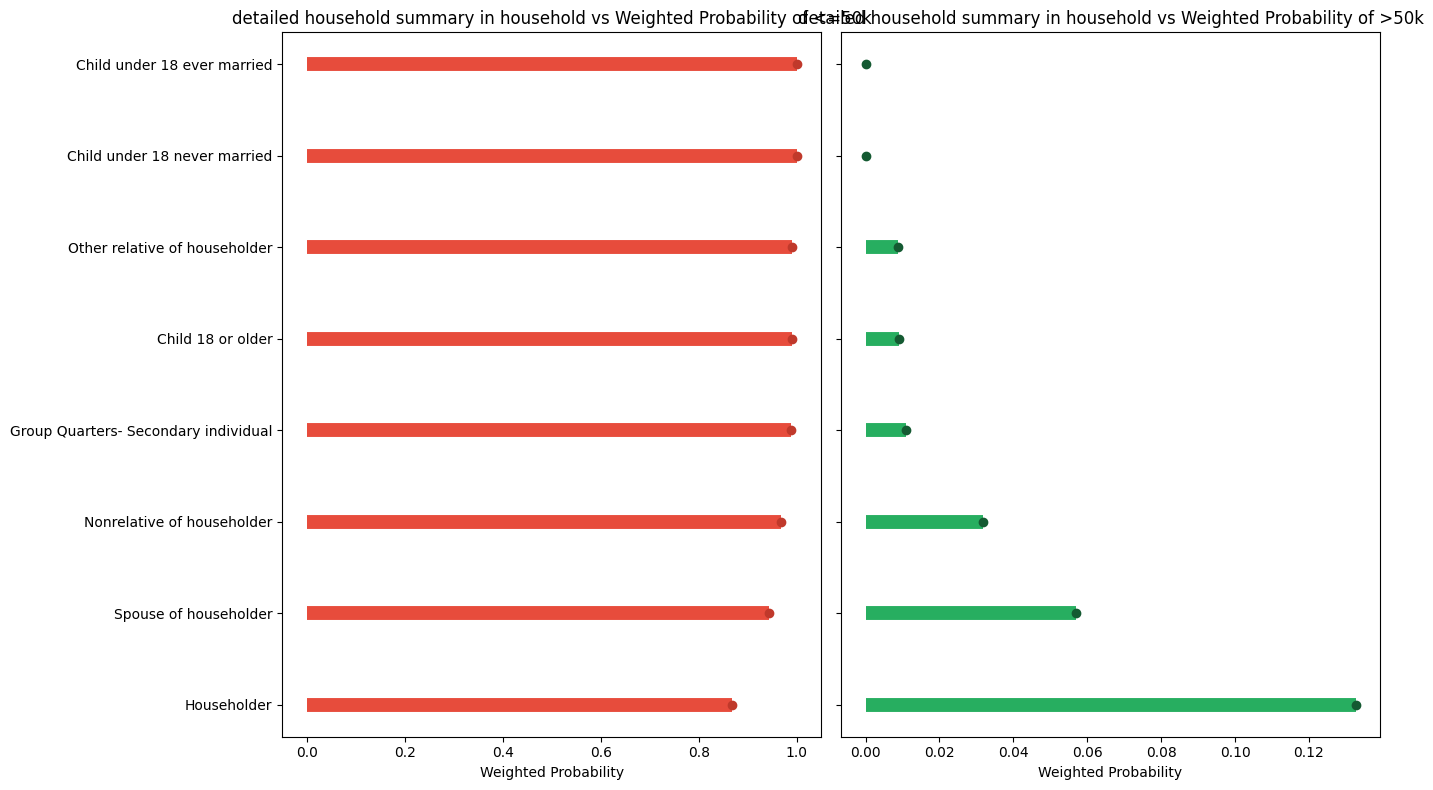

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


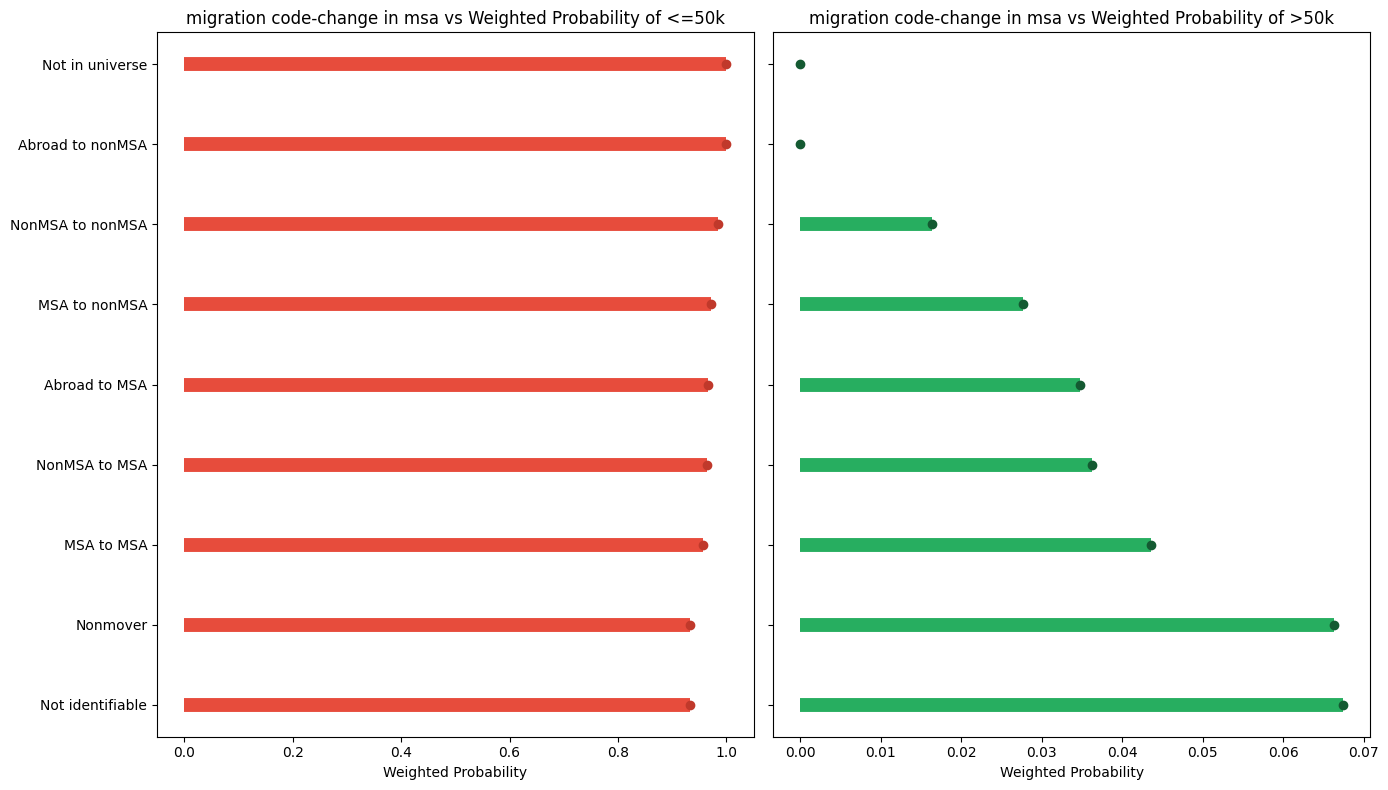

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


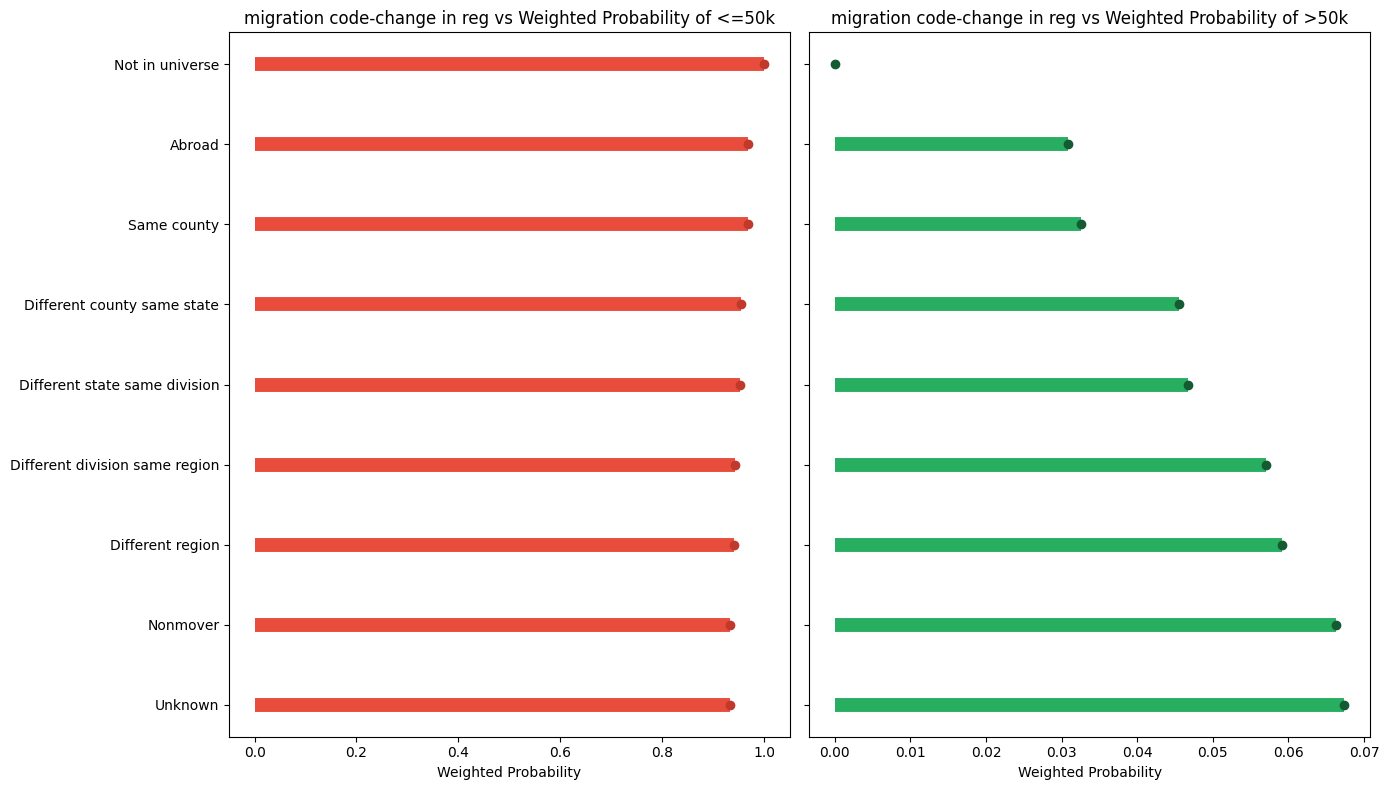

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


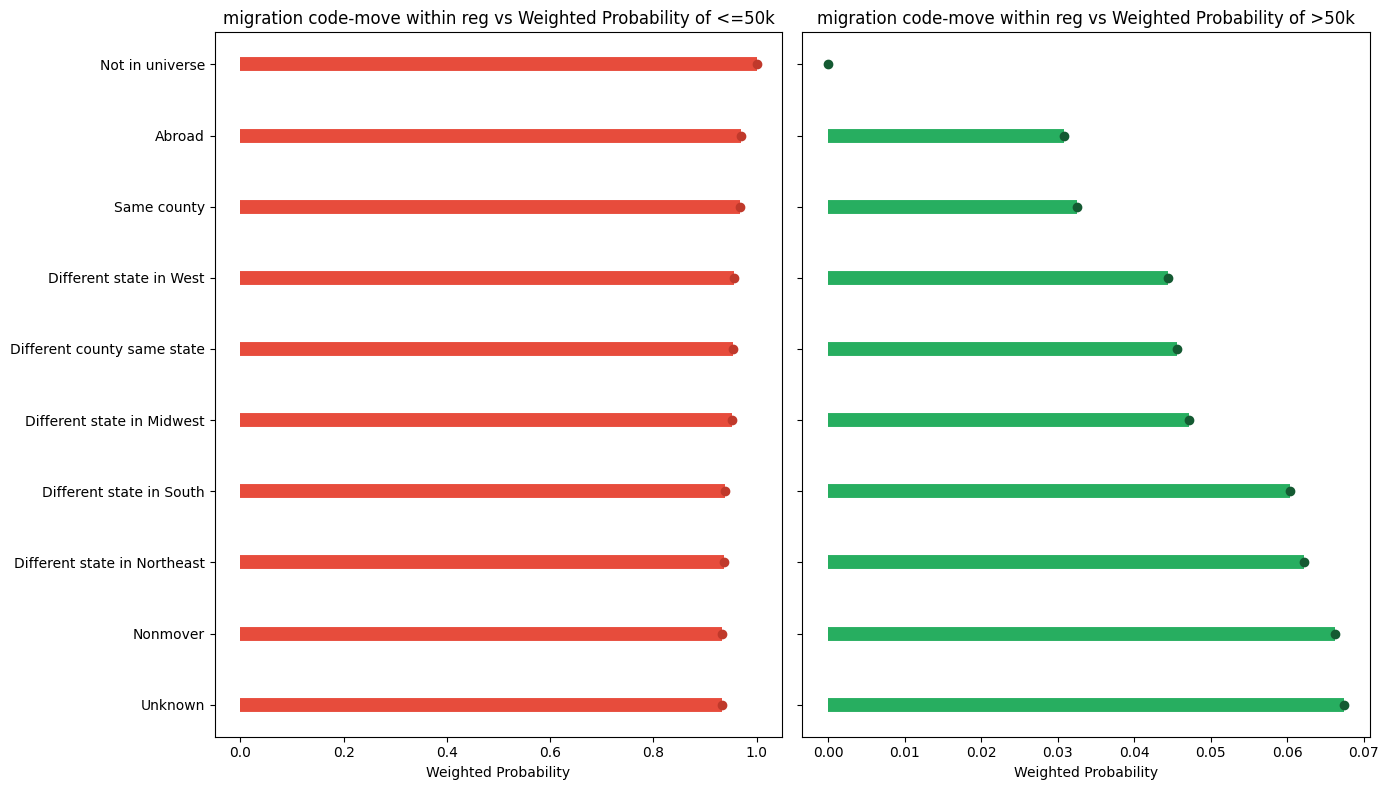

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


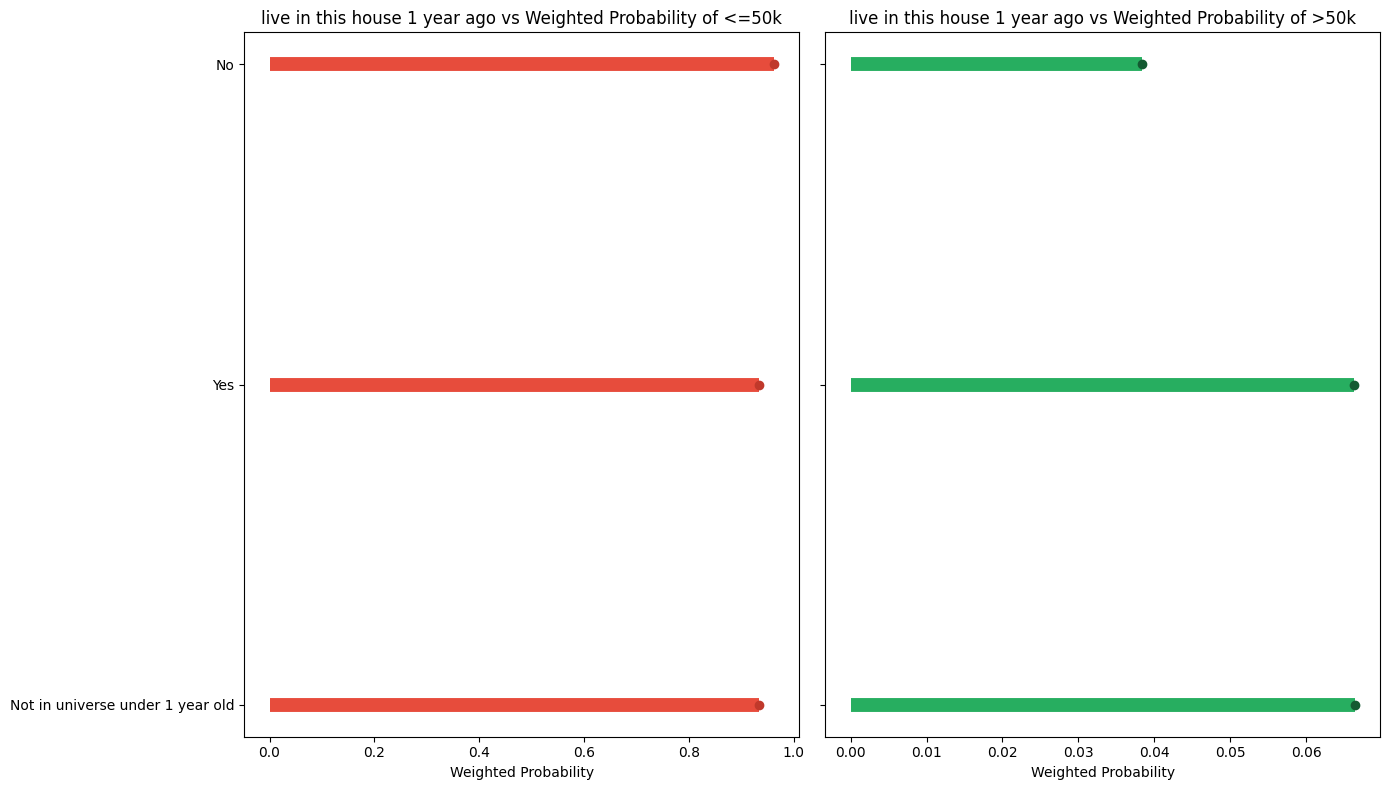

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


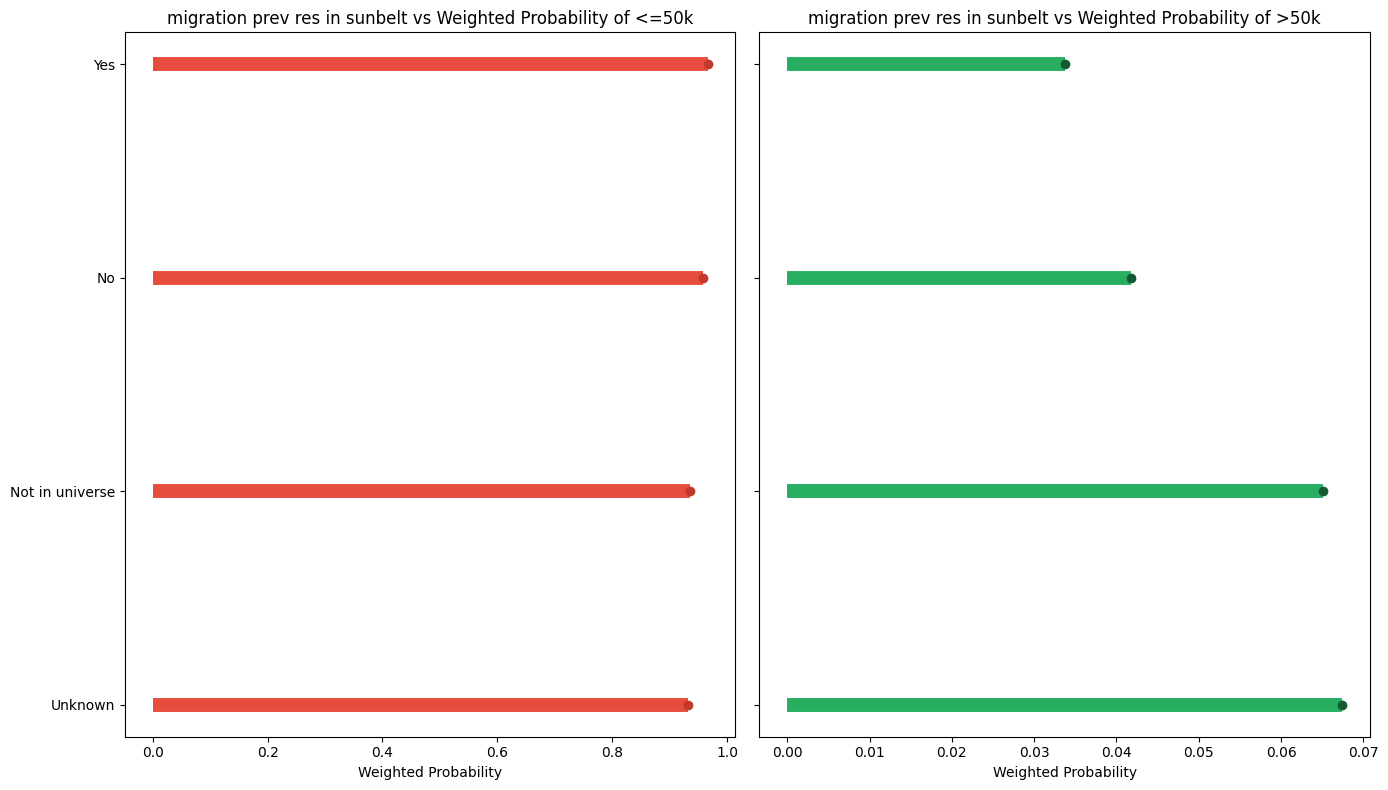

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


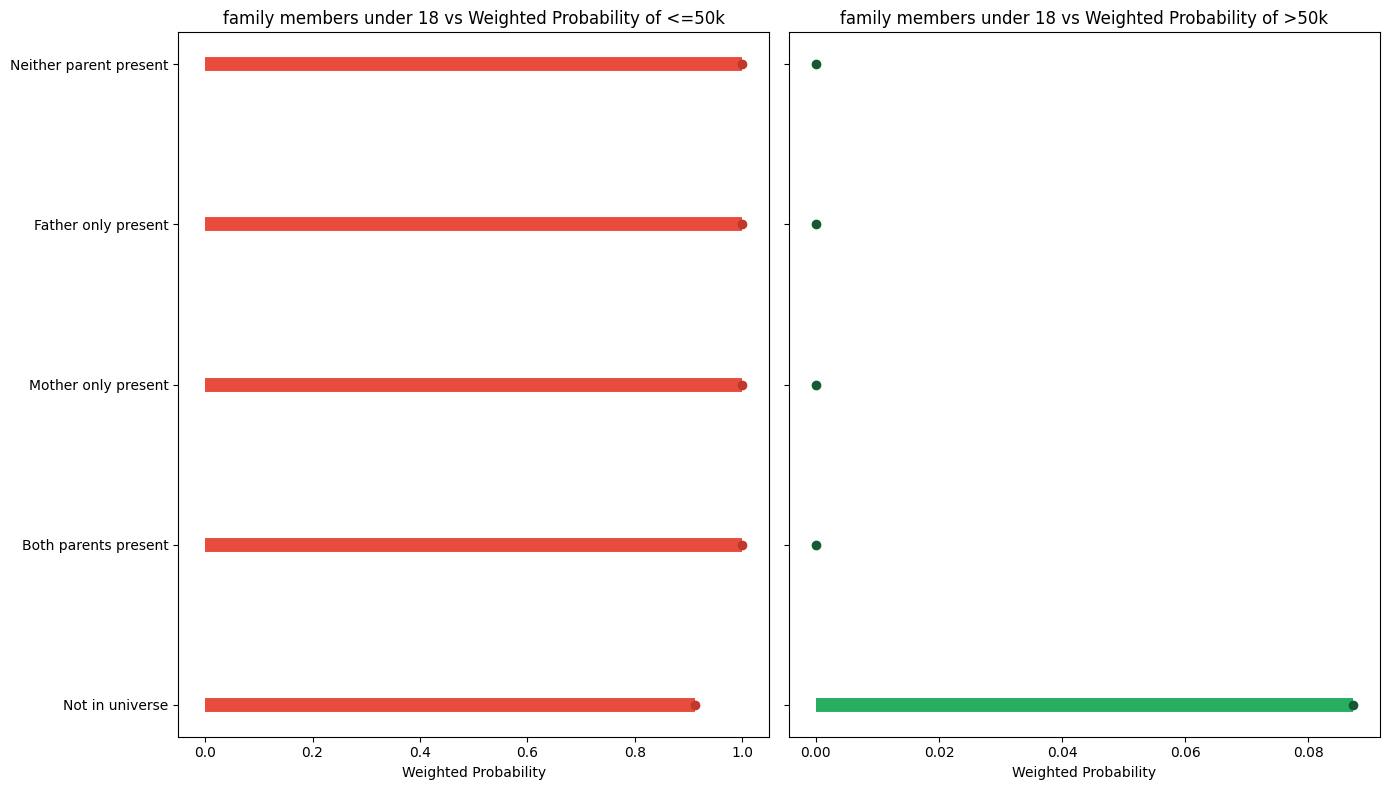

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


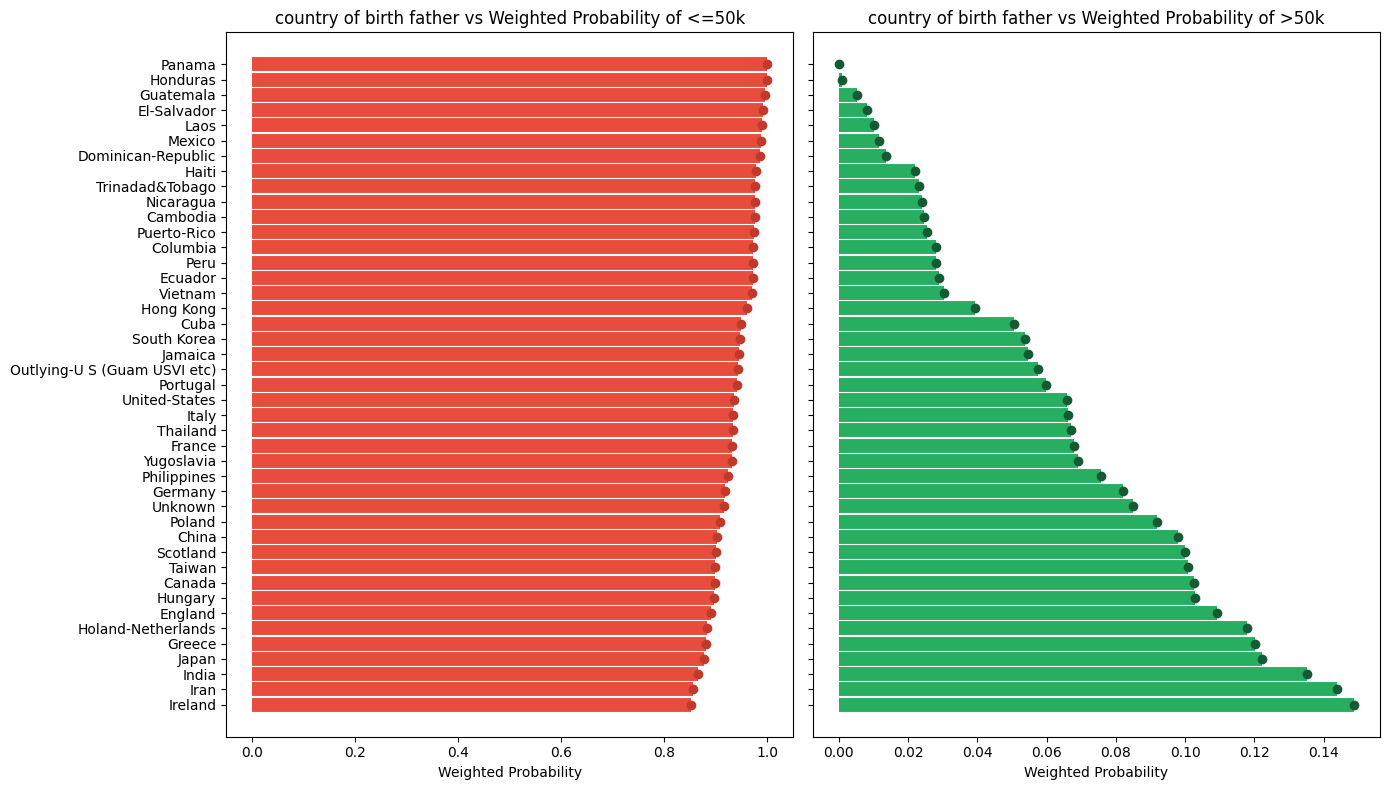

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


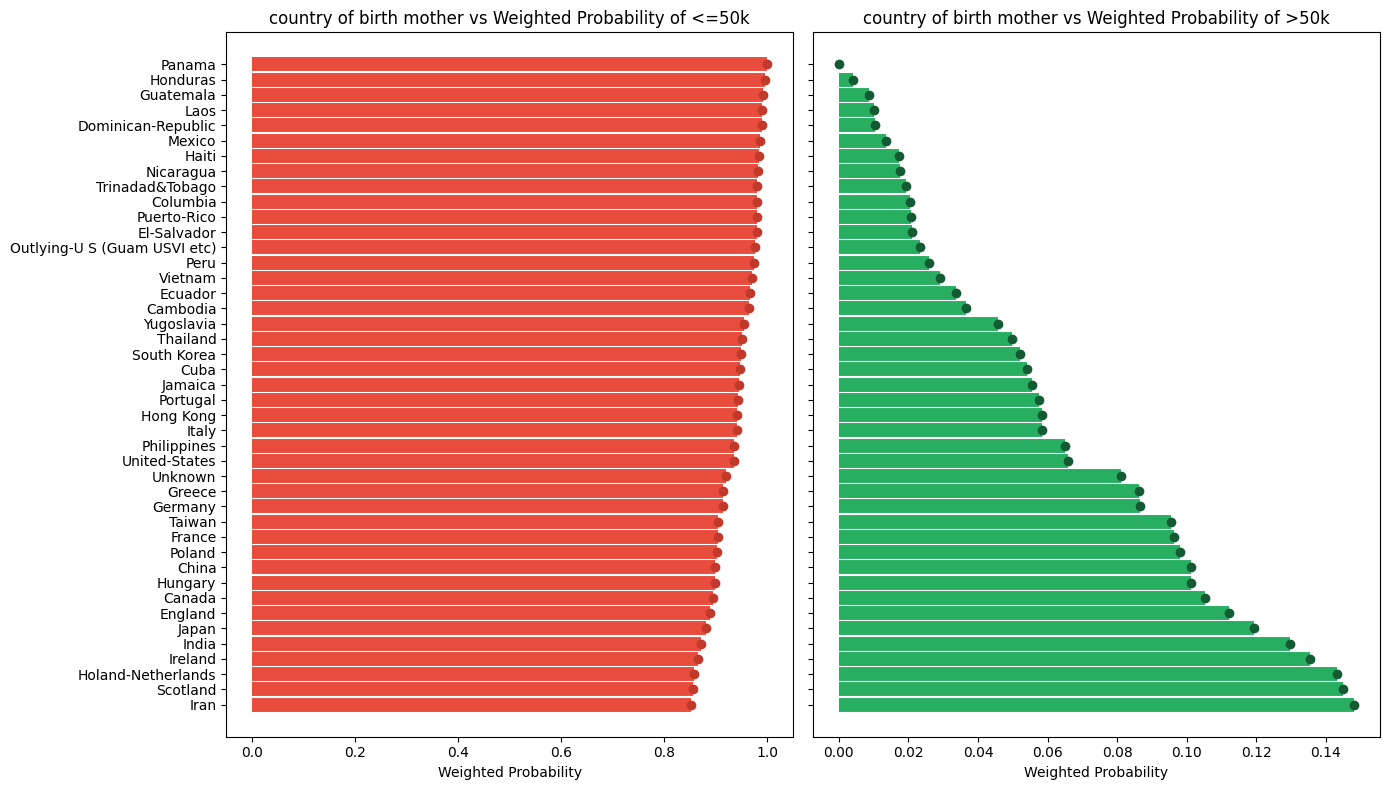

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


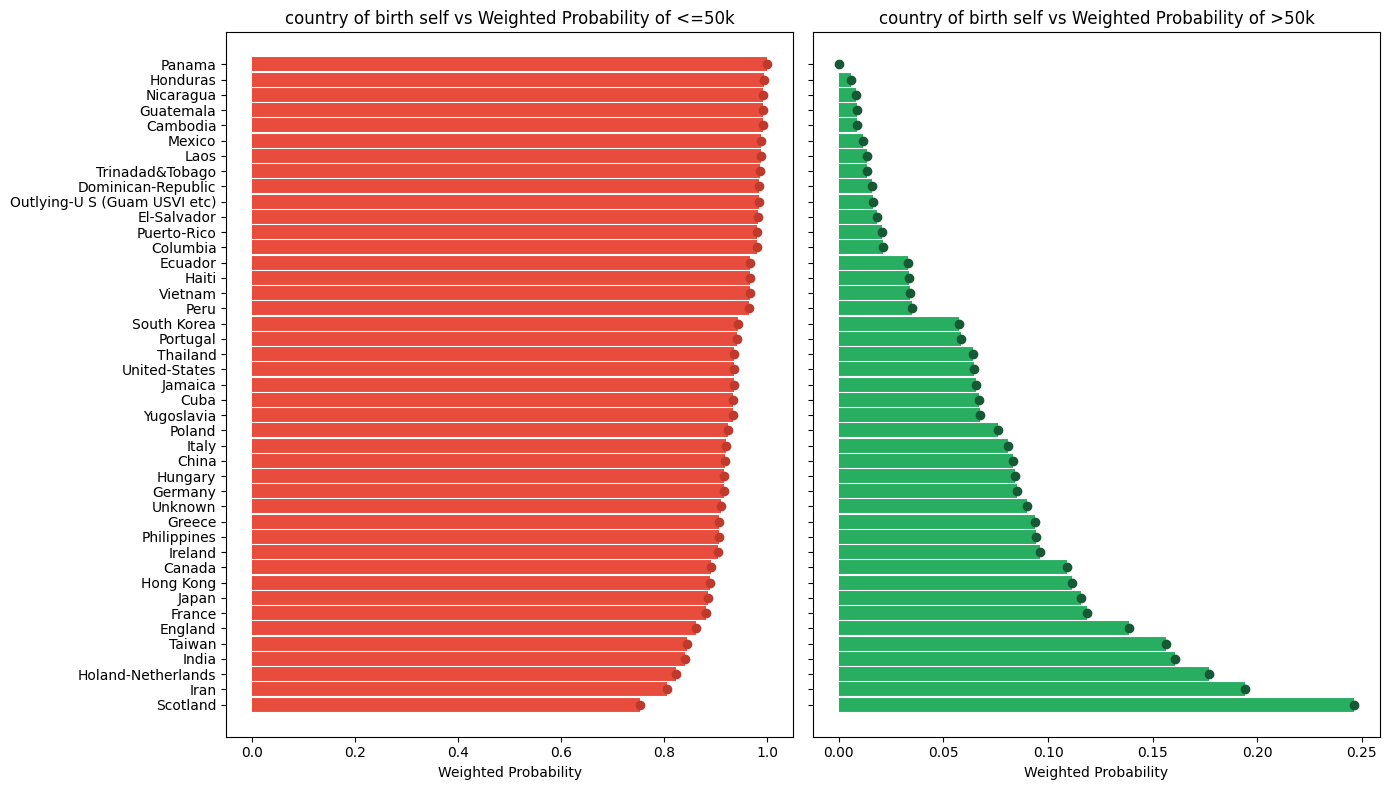

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


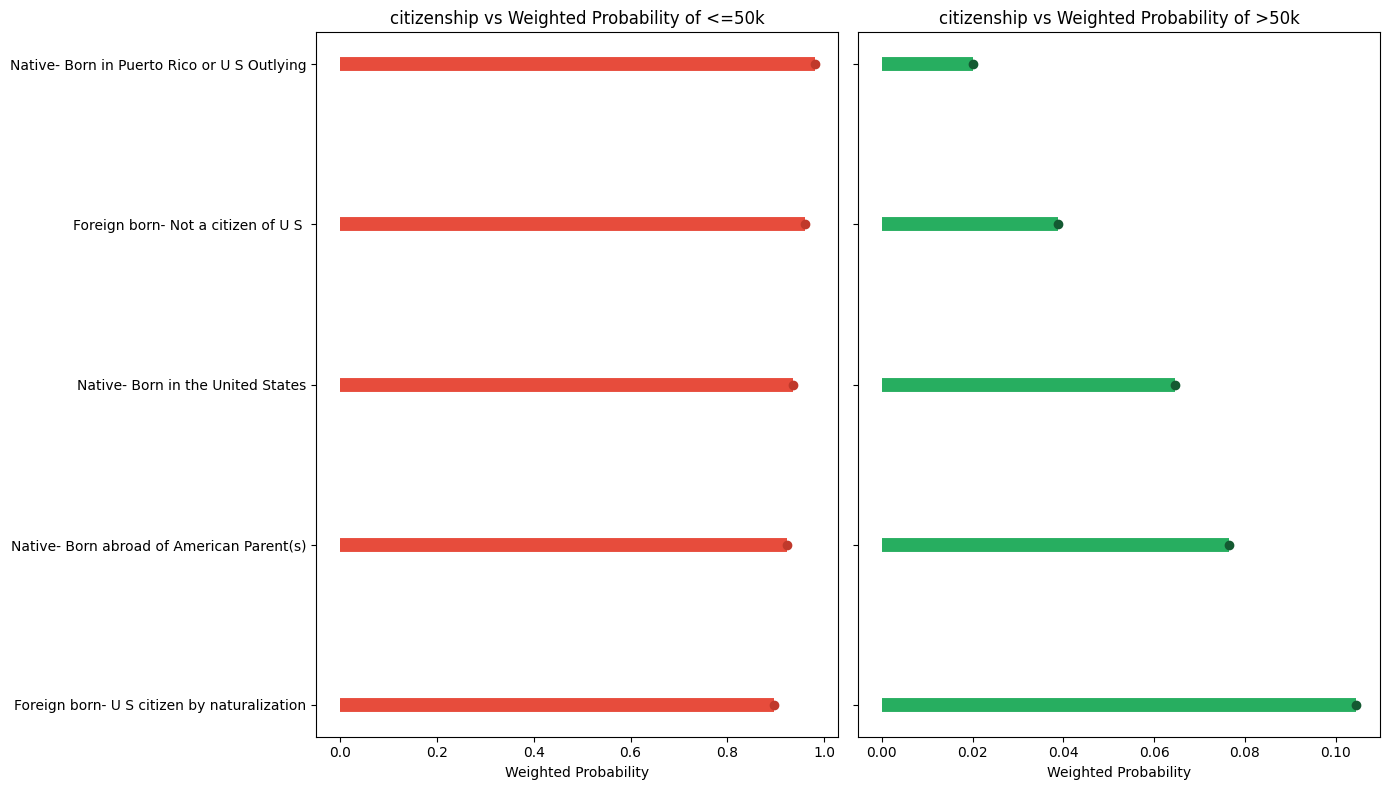

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


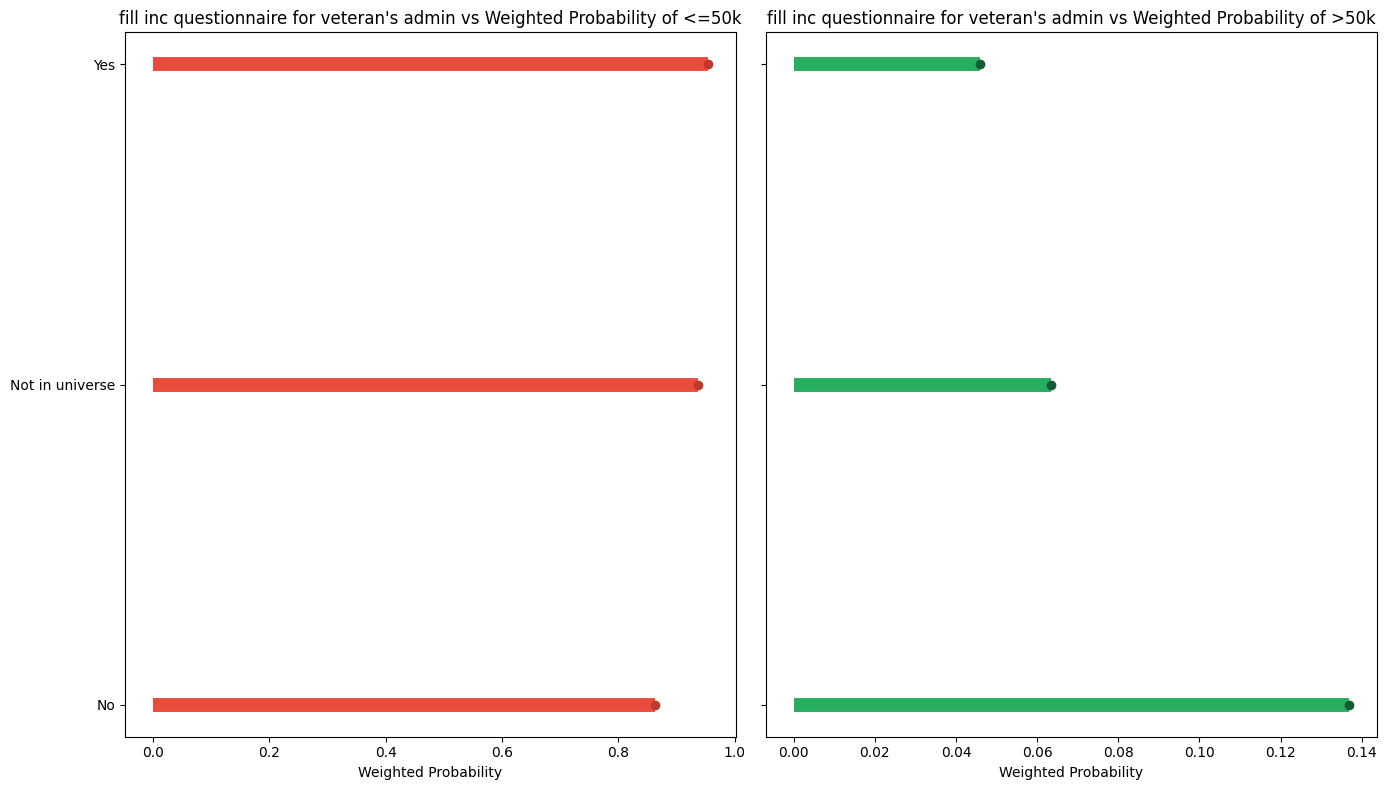

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


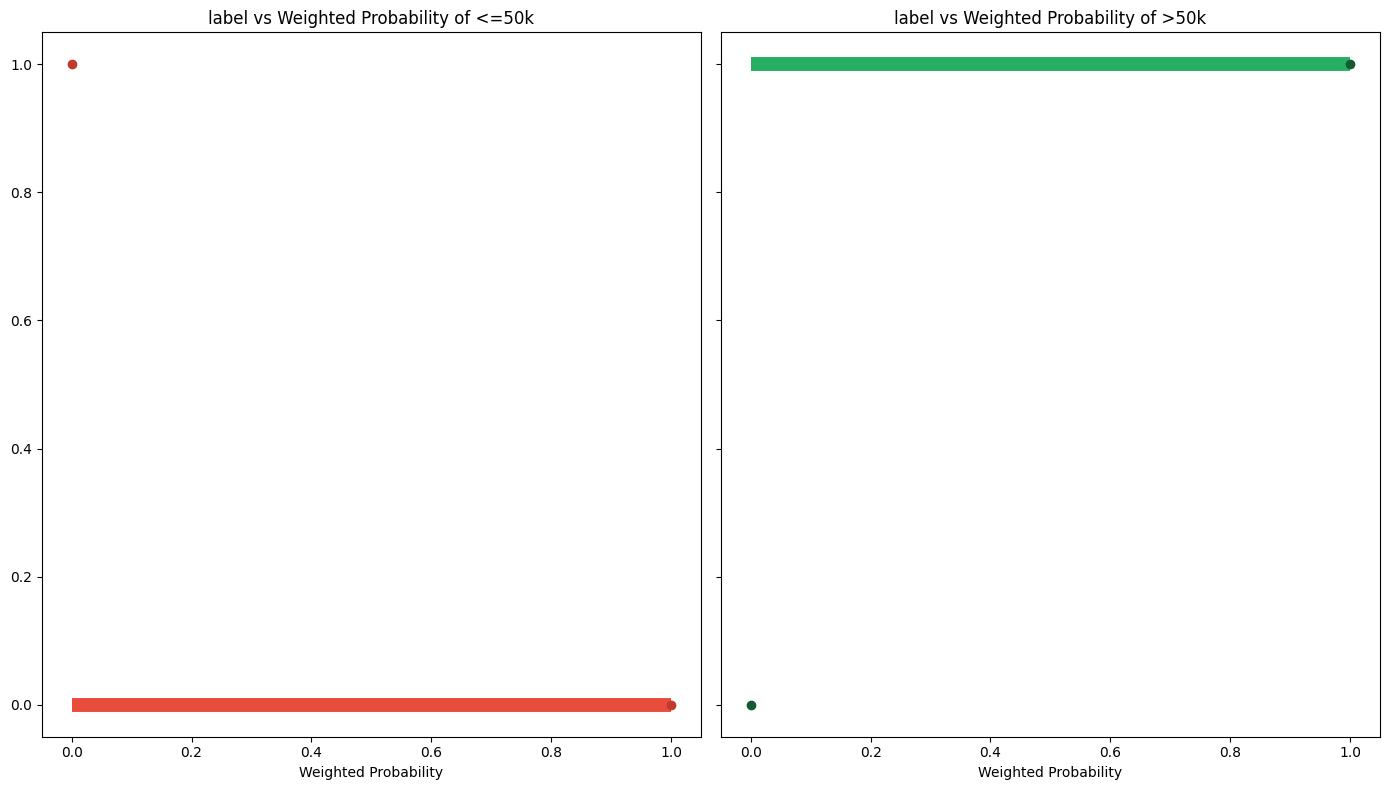

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


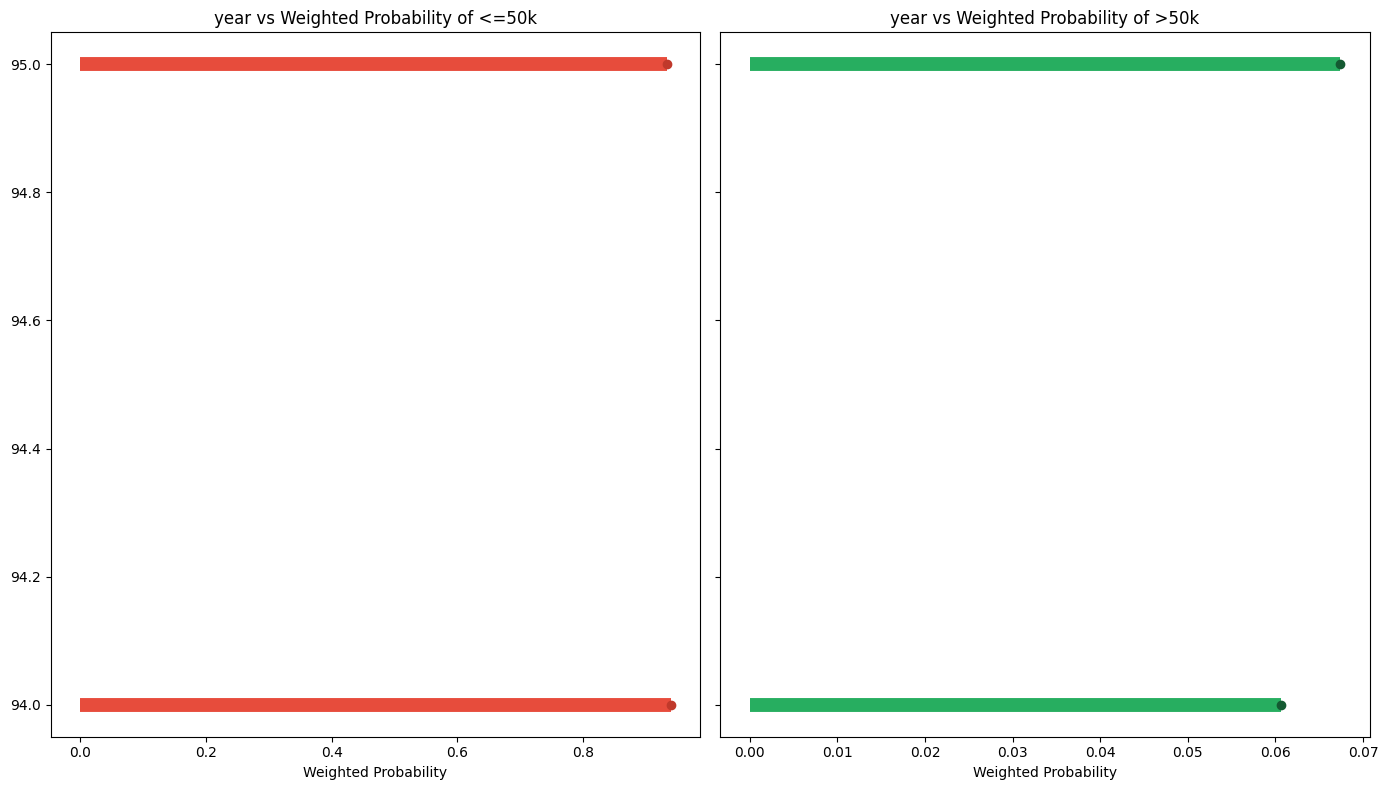

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


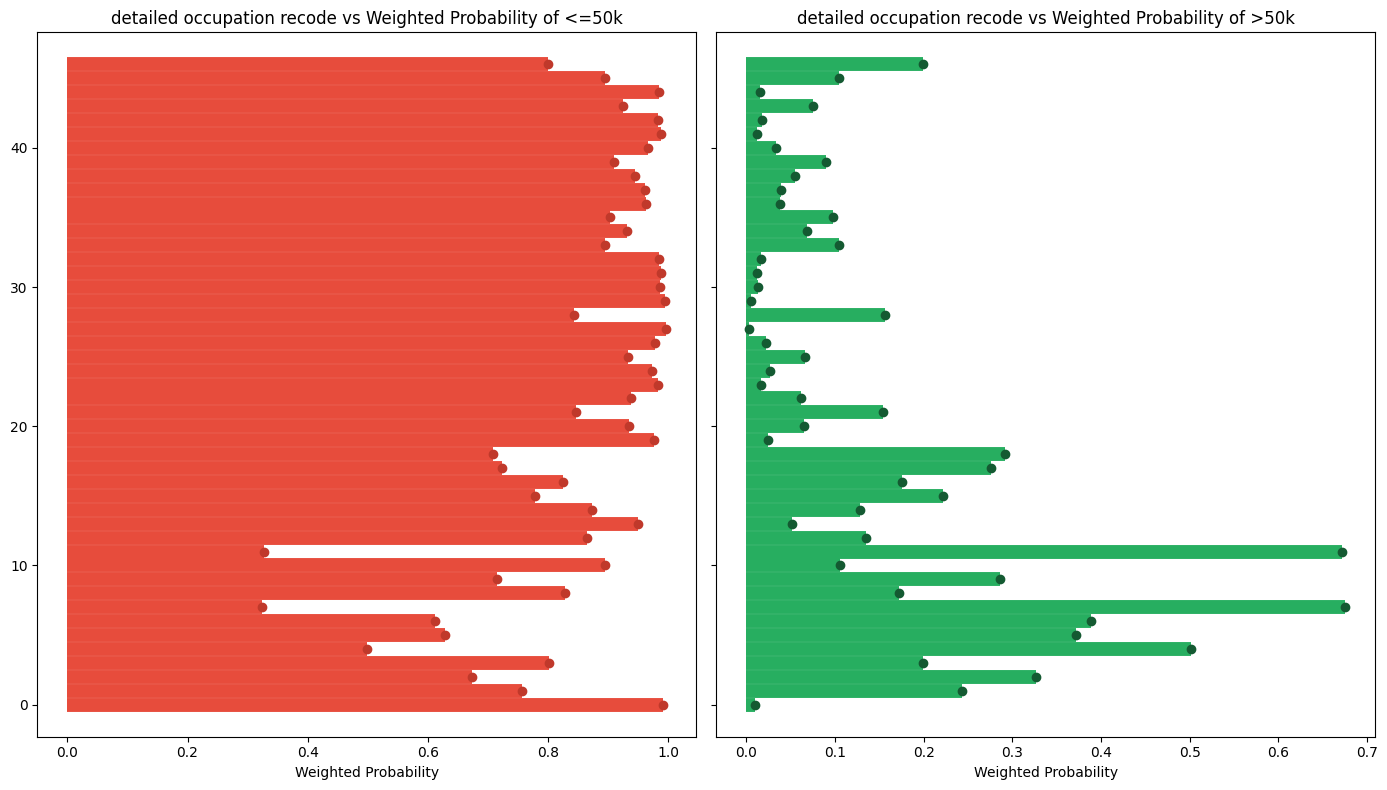

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


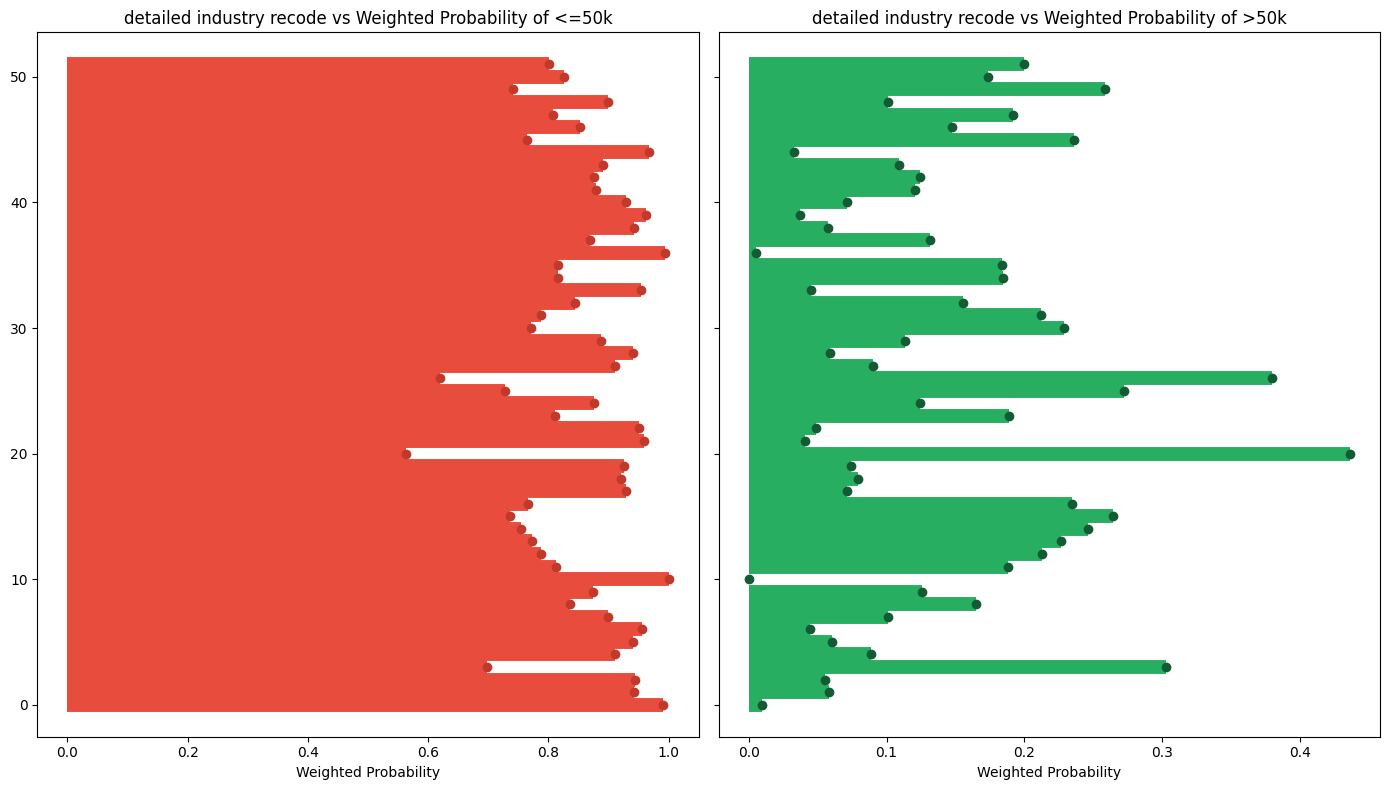

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


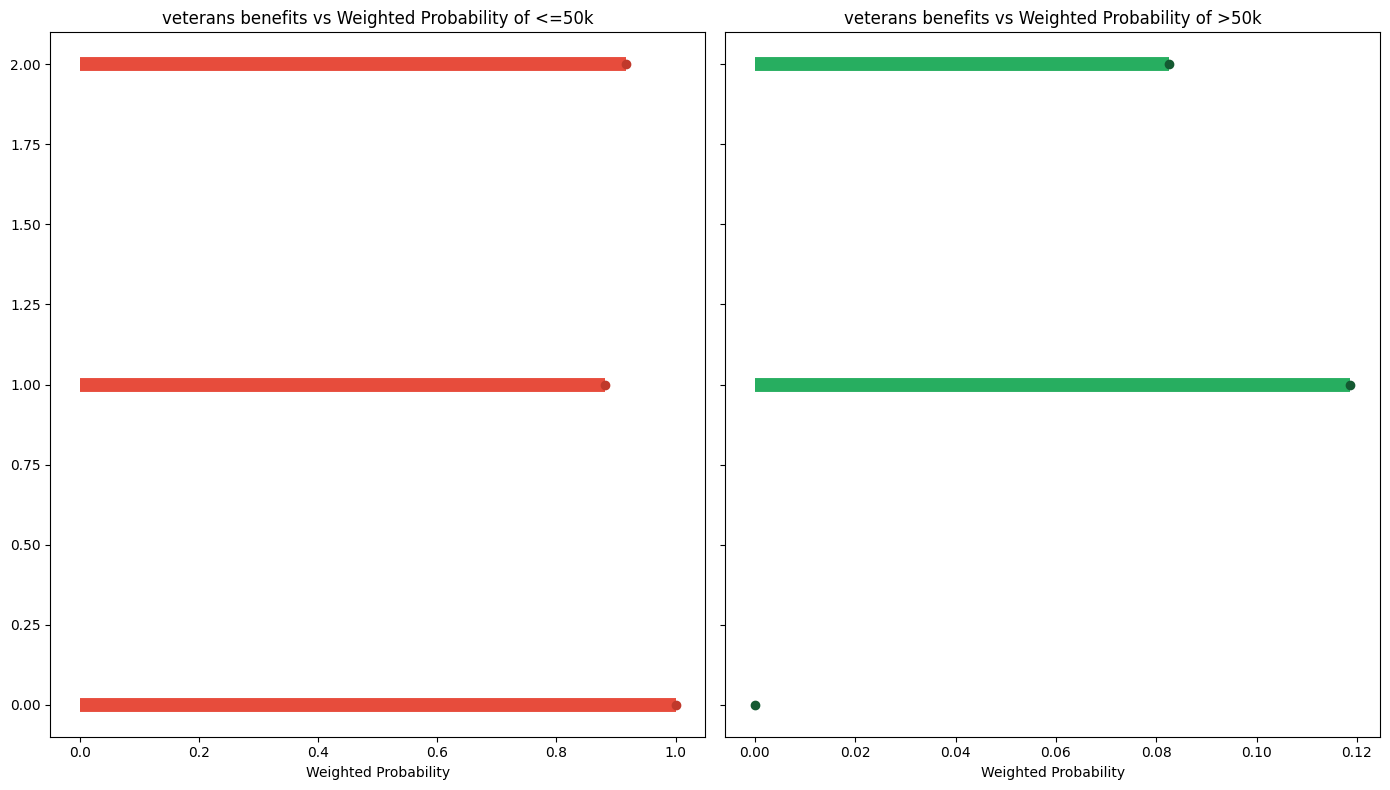

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


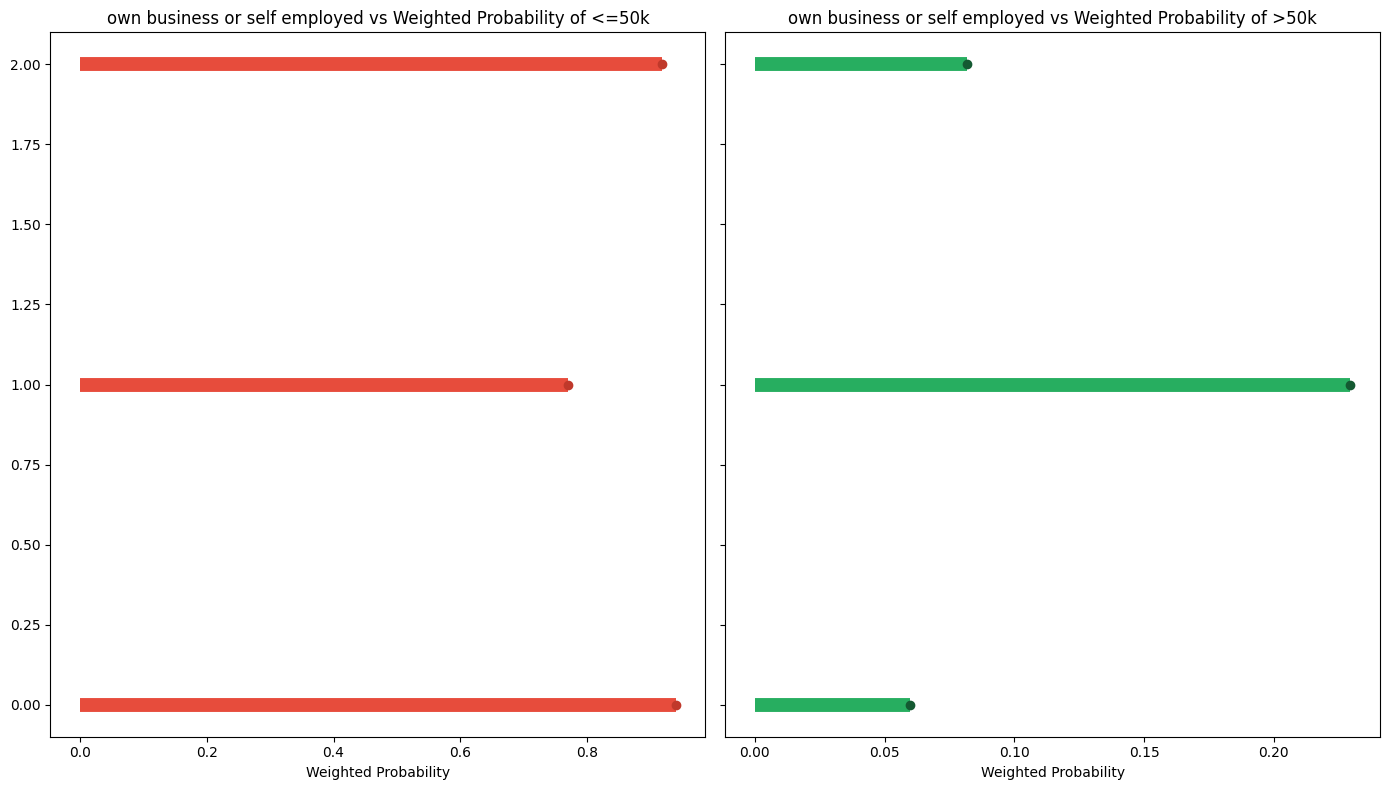

/tmp/ipython-input-3460639137.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
/tmp/ipython-input-3460639137.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())


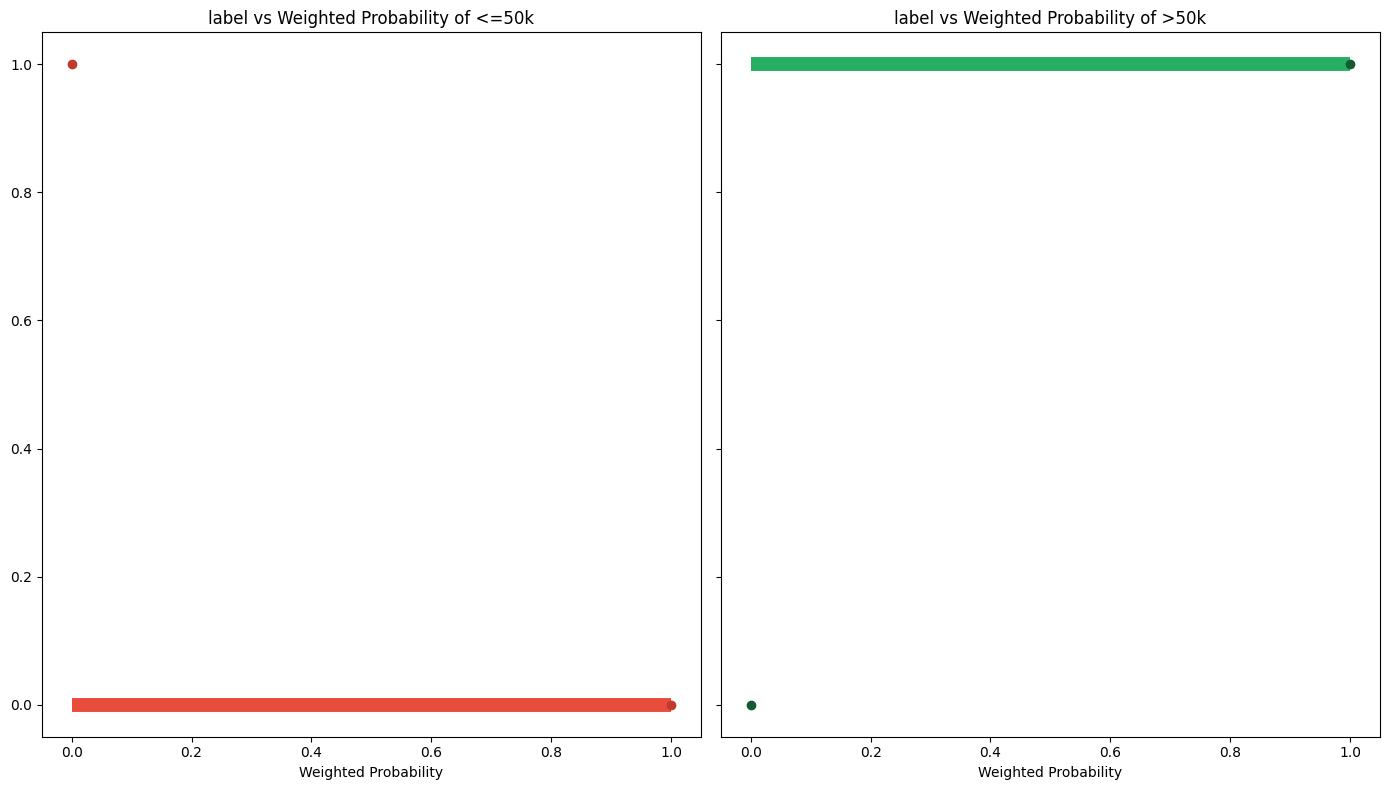

In [45]:
for col in categorical_cols:


# Calculate weighted probability of <50k for each education group
    low_income = (
    df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 0)).sum() / group['weight'].sum())
    .sort_values()
    )

    # Calculate weighted probability of >50k for each education group
    high_income = (
    df.groupby(col).apply(lambda group: (group['weight'] * (group['label'] == 1)).sum() / group['weight'].sum())
    .sort_values()
    )

    # Side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14,8), sharey=True)

    # <50k
    axes[0].hlines(
    y=low_income.index,
    xmin=0,
    xmax=low_income.values,
    color="#e74c3c",
    linewidth=10
    )
    axes[0].plot(
    low_income.values,
    low_income.index,
    "o",
    color="#c0392b"
    )
    axes[0].set_title("{0} vs Weighted Probability of <=50k".format(col))
    axes[0].set_xlabel("Weighted Probability")

    # >50k
    axes[1].hlines(
    y=high_income.index,
    xmin=0,
    xmax=high_income.values,
    color="#27ae60",
    linewidth=10
    )
    axes[1].plot(
    high_income.values,
    high_income.index,
    "o",
    color="#145a32"
    )
    axes[1].set_title("{0} vs Weighted Probability of >50k".format(col))
    axes[1].set_xlabel("Weighted Probability")

    plt.tight_layout()
    plt.show()

## 4. Feature Engineering & Encoding

In [15]:
## grouping certain distinct values of Education column under one commnon bin to reduce the feature space of this specific column
df_filtered['education'].unique()

df_filtered['education'].replace(['7th and 8th grade', '5th or 6th grade' ,'1st 2nd 3rd or 4th grade', 'Less than 1st grade', '9th grade', '10th grade'], "Kindergarden to 10th grade", inplace = True)
df_filtered['education'].unique()

df_filtered.loc[df_filtered['own business or self employed']==2]['class of worker'].value_counts()

# Weighted cross-tab
cross_tab = df_filtered.pivot_table(
    index='own business or self employed',
    columns='class of worker',
    values='weight',
    aggfunc='sum',
    fill_value=0
)

# Convert to proportions within each own_business category
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0)

display(cross_tab)
print("\nWeighted proportions:")
display(cross_tab_pct)

df_filtered.drop(columns=['own business or self employed'], inplace=True)


/tmp/ipython-input-2550983624.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['education'].replace(['7th and 8th grade', '5th or 6th grade' ,'1st 2nd 3rd or 4th grade', 'Less than 1st grade', '9th grade', '10th grade'], "Kindergarden to 10th grade", inplace = True)


class of worker,Federal government,Local government,Never worked,Not in universe,Private,Self-employed-incorporated,Self-employed-not incorporated,State government,Without pay
own business or self employed,,,,,,,,,
0,4355772.66,11171760.06,797549.74,1.689548e+08,1.052477e+08,4956678.16,12375835.63,5610448.98,229336.35
1,131107.98,362444.33,0.00,1.927522e+05,2.896013e+06,319410.78,619742.90,264121.30,4763.28
2,567023.04,2214145.84,10108.52,1.708953e+06,2.102271e+07,376051.25,1519906.84,1291150.40,31643.25



Weighted proportions:


class of worker,Federal government,Local government,Never worked,Not in universe,Private,Self-employed-incorporated,Self-employed-not incorporated,State government,Without pay
own business or self employed,,,,,,,,,
0,0.013885,0.035613,0.002542,0.538587,0.335505,0.015801,0.039451,0.017885,0.000731
1,0.027369,0.075661,0.000000,0.040238,0.604551,0.066678,0.129373,0.055136,0.000994
2,0.019728,0.077036,0.000352,0.059459,0.731436,0.013084,0.052882,0.044923,0.001101


In [16]:
## Thought process is to check if the independent variables like country of mother, country of father and country of myself which among these are most significant
## or has impact on the target "label" variable in our data.

results = []

for col in categorical_cols:
  if col!='label' and col!='own business or self employed' and col!='weight':
    # Create a weighted contingency table
    weighted_table = df_filtered.pivot_table(
        index=col,
        columns='label',
        values='weight',
        aggfunc='sum',
        fill_value=0
    )

    # Compute Chi-square manually with weighted counts
    observed = weighted_table.values
    total = observed.sum()
    row_sums = observed.sum(axis=1).reshape(-1,1)
    col_sums = observed.sum(axis=0).reshape(1,-1)
    expected = row_sums @ col_sums / total  # outer product divided by total

    chi2_stat = ((observed - expected)**2 / expected).sum()
    dof = (observed.shape[0]-1)*(observed.shape[1]-1)

    # Approximate p-value using scipy's chi2 distribution
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(chi2_stat, dof)

    results.append({
        'Column': col,
        'Chi2 Statistic': chi2_stat,
        'p-value': p_value,
        'Degrees of Freedom': dof,
        'Significant (p<0.05)': 'Yes' if p_value < 0.001 else 'No'
    })

chi2_summary_weighted = pd.DataFrame(results)
chi2_summary_weighted.sort_values(by='Chi2 Statistic', ascending=False, inplace=True)
display(chi2_summary_weighted)

## However, the test proved that the because of the large sample size (n in millions) and the high cardinality ( around 51 distinct values for the categorical column
## s country of mothers birth etc, Chi-Square test of independence proved to be not much use as it shows all the features are veru significant and are associated
## with target variable)



,Column,Chi2 Statistic,p-value,Degrees of Freedom,Significant (p<0.05)
29,detailed occupation recode,6.773089e+07,0.0,46,Yes
1,education,5.332970e+07,0.0,11,Yes
5,major occupation code,4.704177e+07,0.0,14,Yes
30,detailed industry recode,3.008026e+07,0.0,51,Yes
4,major industry code,2.697273e+07,0.0,23,Yes
0,class of worker,2.395804e+07,0.0,8,Yes
15,detailed household and family stat,2.108600e+07,0.0,37,Yes
12,tax filer stat,1.912550e+07,0.0,5,Yes
16,detailed household summary in household,1.863258e+07,0.0,7,Yes
3,marital stat,1.426183e+07,0.0,6,Yes


In [17]:
y = df_filtered['label']
Cp = df_filtered[['country of birth self']]
CmCf = df_filtered[['country of birth mother', 'country of birth father']]

pipe_1 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_1.fit(Cp, y, clf__sample_weight=df_filtered['weight'])
pred_1 = pipe_1.predict_proba(Cp)[:,1]
auc_1 = roc_auc_score(y, pred_1, sample_weight=df_filtered['weight'])

X_full = pd.concat([Cp, CmCf], axis=1)

pipe_2 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_2.fit(X_full, y, clf__sample_weight=df_filtered['weight'])
pred_2 = pipe_2.predict_proba(X_full)[:,1]
auc_2 = roc_auc_score(y, pred_2, sample_weight=df_filtered['weight'])

print("AUC (Cp only):", auc_1)
print("AUC (Cp + parents):", auc_2)
print("ΔAUC:", auc_2 - auc_1)


AUC (Cp only): 0.5318480054488217
AUC (Cp + parents): 0.5564751863867918
ΔAUC: 0.024627180937970117


In [18]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
deltas = []

for train, test in skf.split(df_filtered, y):
    Xp_train, Xp_test = Cp.iloc[train], Cp.iloc[test]
    Xf_train, Xf_test = X_full.iloc[train], X_full.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    w_train, w_test = df_filtered['weight'].iloc[train], df_filtered['weight'].iloc[test]

    pipe_1.fit(Xp_train, y_train, clf__sample_weight=w_train)
    pipe_2.fit(Xf_train, y_train, clf__sample_weight=w_train)

    auc1 = roc_auc_score(y_test, pipe_1.predict_proba(Xp_test)[:,1], sample_weight=w_test)
    auc2 = roc_auc_score(y_test, pipe_2.predict_proba(Xf_test)[:,1], sample_weight=w_test)

    deltas.append(auc2 - auc1)

np.mean(deltas), np.std(deltas)

(np.float64(0.023427035592244006), np.float64(0.004733789562796667))

In [19]:
df_filtered['detailed household and family stat'].unique()
import re

def parse_household_rel(s):
    # Relation
    if "Householder" in s:
        relation = "Householder"
    elif "Spouse" in s:
        relation = "Spouse"
    elif "Child" in s:
        relation = "Child"
    elif "Grandchild" in s:
        relation = "Grandchild"
    elif "Other Rel" in s:
        relation = "Other_Rel"
    elif "RP" in s:
        relation = "RP_unrelated"
    elif "Secondary individual" in s:
        relation = "Secondary"
    elif "Nonfamily householder" in s:
        relation = "Nonfamily_householder"
    elif "In group quarters" in s:
        relation = "In_group_quarters"
    else:
        relation = "Other"

    # Age group
    if "<18" in s:
        age_group = "<18"
    elif "18+" in s:
        age_group = "18+"
    else:
        age_group = "Unknown"

    # Marital status
    if "never marr" in s or "never married" in s:
        marital = "Never_married"
    elif "ever marr" in s:
        marital = "Ever_married"
    elif "spouse" in s:
        marital = "Spouse"
    else:
        marital = "Unknown"

    # Subfamily membership
    if "in subfamily" in s:
        subfamily = "In_subfamily"
    elif "not in subfamily" in s:
        subfamily = "Not_in_subfamily"
    elif "child of subfamily RP" in s:
        subfamily = "Child_of_subfamily_RP"
    else:
        subfamily = "Unknown"

    return pd.Series([relation, age_group, marital, subfamily])

df_filtered[["relation", "age_group", "marriage_status", "subfamily"]] = df_filtered["detailed household and family stat"].apply(parse_household_rel)


In [20]:
## I have checked whether the newly created age_group and marriage_status columns exactly match
## existing age and marital stat columns
res1 = []
res2 = []
for index, row in df_filtered.iterrows():
  if row['age_group'] == '18+' and row['age']<18:
    res1.append(index)
  if row['age_group'] == '<18' and row['age']>=18:
    res2.append(index)

print("RESULT_age", res1, res2)
res1 = []
res2 = []
for index, row in df_filtered.iterrows():
  if row['marriage_status'] in ['Ever_married', 'Spouse'] and row['marital stat'] not in ['Married-civilian spouse present', 'Separated',
       'Married-spouse absent', 'Married-A F spouse present', 'Widowed', 'Divorced']:
    res1.append(index)
  if row['marriage_status'] == 'Never_married' and row['marital stat']!='Never married':
    res2.append(index)

print("RESULT_marriage_status", res1, res2)

RESULT_age [] []
RESULT_marriage_status [] []


In [21]:
df_filtered['detailed household summary in household'].unique()

# After observing that 'detailed household summary in household' is a simple version of the column
# 'detailed household and family stat' and using the incremental model approach finding that the detailed
# version added info doesot lead to prediction significance.
# I chose to drop 'detailed household and family stat' column as seen below




array(['Other relative of householder', 'Householder',
       'Child 18 or older', 'Child under 18 never married',
       'Spouse of householder', 'Nonrelative of householder',
       'Group Quarters- Secondary individual',
       'Child under 18 ever married'], dtype=object)

In [22]:
y = df_filtered['label']
Cg = df_filtered[['detailed household summary in household']]
Cd = df_filtered[['detailed household and family stat']]

pipe_1 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_1.fit(Cg, y, clf__sample_weight=df_filtered['weight'])
pred_1 = pipe_1.predict_proba(Cg)[:,1]
auc_1 = roc_auc_score(y, pred_1, sample_weight=df_filtered['weight'])

X_full = pd.concat([Cg, Cd], axis=1)

pipe_2 = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_2.fit(X_full, y, clf__sample_weight=df_filtered['weight'])
pred_2 = pipe_2.predict_proba(X_full)[:,1]
auc_2 = roc_auc_score(y, pred_2, sample_weight=df_filtered['weight'])

print("AUC (Cg only):", auc_1)
print("AUC (Cg + Cd):", auc_2)
print("ΔAUC:", auc_2 - auc_1)

df_filtered.drop(columns=['detailed household and family stat'], inplace=True)



AUC (Cg only): 0.7573354213132386
AUC (Cg + Cd): 0.7756435235178194
ΔAUC: 0.01830810220458079


In [23]:
df_filtered.drop(columns=["relation", "age_group", "marriage_status", "subfamily"], inplace=True)

In [24]:
combinations = df_filtered[['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg']].drop_duplicates()
print(combinations.shape[0])

# Though the above 3 columns have heirachial relation, I chose one hot encoding for each of the columns
# instead of performing one hot encoding for 73 columns
# I chose to have less features over the loss of information.

state_combi = df_filtered[['region of previous residence', 'state of previous residence']].drop_duplicates()
print(state_combi.shape[0])

# Create hierarchical interaction column
df_filtered['region_state_previous_residence'] = df_filtered['region of previous residence'] + "_" + df_filtered['state of previous residence']
df_filtered.drop(columns = ['region of previous residence','state of previous residence'], inplace=True)

# perform one hot encoding for thse columns


#decided to follow this approach with regards to country
#option 1: one hot encoding on 3 coluntry columns and apply logistic regression
#option 2: group c1, c2 mother and father country column values to same, different,
#unknown and perform one hot encoding with myself country and newly created column
#Before I planned to consider the above optiion, need to the check the proportion
#so the samples for rare countries, since we have around 42 countries with less than 1% of the records.
# Its better to replace them with other and proceed.

birth_combi = df_filtered[['country of birth father', 'country of birth mother', 'country of birth self']].drop_duplicates()
print(birth_combi)
birth_combi = df_filtered[['country of birth father', 'country of birth mother']].drop_duplicates()
print(birth_combi)

73
53
       country of birth father country of birth mother country of birth self
0                United-States           United-States         United-States
2                      Vietnam                 Vietnam               Vietnam
5                  Philippines           United-States         United-States
11                     Unknown                 Unknown               Unknown
13                    Columbia                Columbia              Columbia
...                        ...                     ...                   ...
197815                 England                  Greece                Canada
198302                    Cuba                  Poland                  Cuba
198413                Scotland                 Unknown         United-States
198590              Yugoslavia                   Italy         United-States
199467                 Jamaica                    Cuba               Jamaica

[1344 rows x 3 columns]
       country of birth father country of bir

In [25]:
weighted_counts = df_filtered.groupby('country of birth father')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.1
rare_countries = weighted_freq[weighted_freq < rare_threshold].index
len(rare_countries)

weighted_counts = df_filtered.groupby('country of birth mother')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.1
rare_countries = weighted_freq[weighted_freq < rare_threshold].index
len(rare_countries)

weighted_counts = df_filtered.groupby('country of birth self')['weight'].sum()
total_weight = weighted_counts.sum()
weighted_freq = weighted_counts / total_weight

# Define threshold for rare countries (e.g., <1% of total weight)
rare_threshold = 0.1
rare_countries = weighted_freq[weighted_freq < rare_threshold].index
len(rare_countries)

# Replace rare countries with 'Other'
columns_with_rare = ['country of birth self','country of birth mother', 'country of birth father']

df_filtered[columns_with_rare] = df_filtered[columns_with_rare].replace(rare_countries, 'Other')

In [26]:
# Extract target before transformation
y_target = df_filtered['label']

# Create a DataFrame with features AND weight for transformation
# 'weight' must be in this DataFrame so it's processed and eventually split
X_features_df = df_filtered.drop(columns=['label'])

# --- Define feature types for ColumnTransformer ---
# Ensure numerical_int_cols is based on the globally defined list (from vQQE4GgdgryS)
# Filter out any numerical_int_cols that might have been dropped from X_features_df
numerical_features_for_ct = [col for col in numerical_int_cols if col in X_features_df.columns]

# IMPORTANT: Add 'weight' to numerical_features_for_ct as it needs to be passed through
if 'weight' in X_features_df.columns and 'weight' not in numerical_features_for_ct:
    numerical_features_for_ct.append('weight')

ordinal_cols = ['education']

# Get all potential nominal columns first
all_potential_nominal_cols = [
    col for col in X_features_df.columns.tolist()
    if col not in numerical_features_for_ct + ordinal_cols
]

# Filter out nominal columns that have only one unique value.
# These columns will produce 0 features with OneHotEncoder(drop='first'),
# but get_feature_names_out() might still generate one name, causing a mismatch.
# This check is crucial to align the number of features with generated names.
nominal_cols = [
    col for col in all_potential_nominal_cols
    if X_features_df[col].nunique() > 1
]

# Ordinal mapping (already defined)
education_order = ['Children', 'Kindergarden to 10th grade', '11th grade', '12th grade no diploma', 'High school graduate', 'Some college but no degree', 'Associates degree-occup /vocational', 'Associates degree-academic program', 'Bachelors degree(BA AB BS)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)', 'Doctorate degree(PhD EdD)']

# ColumnTransformer setup
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_cols),
        ('ordinal', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('numerical', 'passthrough', numerical_features_for_ct) # 'weight' is now part of this
    ],
    remainder='drop' # Drop any other columns not explicitly listed
)

# Transform the features DataFrame (which now includes 'weight')
X_processed = preprocessor.fit_transform(X_features_df)

# Generate column names for the processed numpy array
import pandas as pd
processed_feature_names = preprocessor.get_feature_names_out()
df_encoded = pd.DataFrame(X_processed, columns=processed_feature_names)

df_encoded.shape

# Store the prefixed numerical column names for scaling (EXCLUDING weight)
# The scaler will be applied to these columns.
# We need to make sure 'numerical__weight' is NOT in this list for scaling.
global numerical_cols_for_scaling
numerical_cols_for_scaling = [f'numerical__{col}' for col in numerical_int_cols if col in X_features_df.columns]


## 5. Train-Test Split & Scaling

In [27]:
# X is the df_encoded containing all features and 'weight'
X = df_encoded
y = y_target

# Step 1: split off test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Step 2: split train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15
    stratify=y_temp,
    random_state=42
)


# Extract sample weights after the split
sample_weights_train = X_train['numerical__weight'] # 'weight' is passed as 'numerical__weight' by CT
sample_weights_test = X_test['numerical__weight']   # 'weight' is passed as 'numerical__weight' by CT
sample_weights_val = X_val['numerical__weight']     # 'weight' is passed as 'numerical__weight' by CT

# Drop the 'weight' column from X_train and X_test now that it's extracted
X_train = X_train.drop(columns=['numerical__weight'])
X_test = X_test.drop(columns=['numerical__weight'])
X_val = X_val.drop(columns=['numerical__weight'])

scaler = StandardScaler()

# Use the globally defined numerical_cols_for_scaling (which explicitly excludes 'weight')
X_train[numerical_cols_for_scaling] = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test[numerical_cols_for_scaling] = scaler.transform(X_test[numerical_cols_for_scaling])
X_val[numerical_cols_for_scaling] = scaler.transform(X_val[numerical_cols_for_scaling])


## 6. Logistic Regression Model

In [28]:
# sample_weights_train and sample_weight_test are now prepared in 61e80e6a
# X_train and X_test are now prepared in 61e80e6a (weight column dropped)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights_train)


LogisticRegression(random_state=42, solver='liblinear')

In [29]:
model_reg = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
model_reg.fit(X_train, y_train, sample_weight=sample_weights_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

## 7. Model Evaluation

In [30]:

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, sample_weight=sample_weights_test)
precision = precision_score(y_test, y_pred, sample_weight=sample_weights_test)
recall = recall_score(y_test, y_pred, sample_weight=sample_weights_test)
f1 = f1_score(y_test, y_pred, sample_weight=sample_weights_test)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nWeighted Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=sample_weights_test))

print('---------------------\n-------------')

y_pred = model_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, sample_weight=sample_weights_test)
precision = precision_score(y_test, y_pred, sample_weight=sample_weights_test)
recall = recall_score(y_test, y_pred, sample_weight=sample_weights_test)
f1 = f1_score(y_test, y_pred, sample_weight=sample_weights_test)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nWeighted Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=sample_weights_test))


Weighted Accuracy: 0.9496
Weighted Precision: 0.7082
Weighted Recall: 0.3750
Weighted F1-Score: 0.4904

Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97 48971734.79000023
           1       0.71      0.38      0.49 3384461.310000003

    accuracy                           0.95 52356196.10000023
   macro avg       0.83      0.68      0.73 52356196.10000023
weighted avg       0.94      0.95      0.94 52356196.10000023

---------------------
-------------
Weighted Accuracy: 0.9496
Weighted Precision: 0.7077
Weighted Recall: 0.3742
Weighted F1-Score: 0.4895

Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97 48971734.79000023
           1       0.71      0.37      0.49 3384461.3100000033

    accuracy                           0.95 52356196.10000023
   macro avg       0.83      0.68      0.73 52356196.10000023
weighted avg       0

## 10. Model Interpretation

In [31]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
})
coef_df['odds_ratio'] = np.exp(coef_df['coefficient'])
coef_df.sort_values('odds_ratio', ascending=False).head(20)


,feature,coefficient,odds_ratio
27,onehot__detailed industry recode_20,1.786649,5.969414
247,onehot__region_state_previous_residence_Northe...,1.745995,5.731602
275,onehot__region_state_previous_residence_West_A...,1.358015,3.888467
253,onehot__region_state_previous_residence_Northe...,1.245358,3.474180
260,onehot__region_state_previous_residence_South_...,1.184560,3.269248
279,onehot__region_state_previous_residence_West_I...,1.098556,2.999831
162,onehot__sex_Male,1.029712,2.800258
172,onehot__full or part time employment stat_PT f...,1.013461,2.755120
185,onehot__detailed household summary in househol...,0.991428,2.695081
20,onehot__detailed industry recode_13,0.988136,2.686223


In [ ]:
## NOTE: Only run this CELL if we have good compute as this takes very long time to converge
# and provide results

# ============================================
# Complete Logistic Regression Hyperparameter
# Optimization with Solver (Optuna)
# ============================================

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# -----------------------------
# Train-test split
# -----------------------------
X = df_encoded
y = y_target
# Note: X_train, y_train, sample_weights_train are globally available from cell 61e80e6a

# -----------------------------
# Optuna objective function
# -----------------------------
def objective(trial):

    C = trial.suggest_float("C", 1e-3, 10, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 0.9)

    model = LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        C=C,
        l1_ratio=l1_ratio,
        max_iter=300,        # IMPORTANT
        n_jobs=-1,
        tol=1e-3             # IMPORTANT
    )

    model.fit(X_train, y_train, sample_weight=sample_weights_train)

    y_val_proba = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(
        y_val,
        y_val_proba,
        sample_weight=sample_weights_val
    )



# -----------------------------
# Run Optuna optimization
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


# -----------------------------
# Best hyperparameters
# -----------------------------
print("Best ROC-AUC:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


# -----------------------------
# Train final model
# -----------------------------
best_model = LogisticRegression(
    **study.best_params,
    max_iter=1000
)

# Train the final model on the full X_train and y_train with full sample_weights_train
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)


In [ ]:
# -----------------------------
# Evaluate on test data
# -----------------------------
y_test_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test ROC-AUC:", test_roc_auc)

## MODEL 2 : Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=500,          # stability in high dimensions
    max_depth=None,            # let trees grow, control later
    min_samples_leaf=50,       # IMPORTANT for weighted data
    max_features="sqrt",       # default but explicit
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_base.fit(
    X_train,
    y_train,
    sample_weight=sample_weights_train
)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=50,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [33]:
from sklearn.metrics import roc_auc_score

y_prob = rf_base.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(
    y_test,
    y_prob,
    sample_weight=sample_weights_test
)

print("Test ROC-AUC:", roc_auc)


Test ROC-AUC: 0.9429994394586635


In [34]:
y_pred = rf_base.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, sample_weight=sample_weights_test)
precision = precision_score(y_test, y_pred, sample_weight=sample_weights_test)
recall = recall_score(y_test, y_pred, sample_weight=sample_weights_test)
f1 = f1_score(y_test, y_pred, sample_weight=sample_weights_test)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nWeighted Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=sample_weights_test))


Weighted Accuracy: 0.8430
Weighted Precision: 0.2788
Weighted Recall: 0.9005
Weighted F1-Score: 0.4257

Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91 48971734.79000023
           1       0.28      0.90      0.43 3384461.310000003

    accuracy                           0.84 52356196.10000023
   macro avg       0.64      0.87      0.67 52356196.10000023
weighted avg       0.95      0.84      0.88 52356196.10000023



In [35]:
# ============================
# NEXT STEPS: Threshold tuning + calibration + comparison
# ============================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    roc_auc_score,
    average_precision_score
)

# ---- 1. Train a constrained Random Forest (precision-aware) ----
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=100,
    min_samples_split=200,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train, sample_weight=sample_weights_train)

# ---- 2. Calibrate probabilities (important for RF) ----
rf_cal = CalibratedClassifierCV(
    rf,
    method="isotonic",
    cv=3
)

rf_cal.fit(X_train, y_train, sample_weight=sample_weights_train)

# ---- 3. Get calibrated probabilities ----
y_prob = rf_cal.predict_proba(X_test)[:, 1]

# ---- 4. Precision–Recall curve with weights ----
precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_prob,
    sample_weight=sample_weights_test
)

pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})



In [36]:
# ---- 5. Choose threshold (example: recall ≈ 0.80) ----
target_recall = 0.80
best_row = pr_df.iloc[(pr_df["recall"] - target_recall).abs().argsort()[:1]]
best_threshold = best_row["threshold"].values[0]

# ---- 6. Apply chosen threshold ----
y_pred_opt = (y_prob >= best_threshold).astype(int)

# ---- 7. Final weighted evaluation ----
print("Chosen threshold:", round(best_threshold, 3))
print("\nWeighted Classification Report:")
print(classification_report(
    y_test,
    y_pred_opt,
    sample_weight=sample_weights_test,
    digits=3
))

print("Weighted ROC-AUC:",
      roc_auc_score(y_test, y_prob, sample_weight=sample_weights_test))
print("Weighted PR-AUC:",
      average_precision_score(y_test, y_prob, sample_weight=sample_weights_test))


Chosen threshold: 0.113

Weighted Classification Report:
              precision    recall  f1-score   support

           0      0.985     0.898     0.939 48971734.79000023
           1      0.350     0.799     0.487 3384461.310000003

    accuracy                          0.891 52356196.10000023
   macro avg      0.668     0.848     0.713 52356196.10000023
weighted avg      0.944     0.891     0.910 52356196.10000023

Weighted ROC-AUC: 0.9367784439795453
Weighted PR-AUC: 0.5756997470635695


In [37]:
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances["group"] = importances["feature"].str.split("_").str[2]
group_importance = importances.groupby("group")["importance"].sum()
print(group_importance[:15])


group
age                                        0.063483
capital gains                              0.024933
capital losses                             0.005538
citizenship                                0.000365
class of worker                            0.061218
country of birth father                    0.000253
country of birth mother                    0.000268
country of birth self                      0.000264
detailed household summary in household    0.074795
detailed industry recode                   0.008276
detailed occupation recode                 0.038336
dividends from stocks                      0.050677
education                                  0.115474
enroll in edu inst last wk                 0.007042
family members under 18                    0.027197
Name: importance, dtype: float64


## Model 3 CatBoost

In [38]:
cat_cols = nominal_cols + ['education']


In [39]:
import numpy as np
from catboost import Pool # Import Pool from catboost

# Identify indices of columns that are categorical after preprocessing
# These are columns that were either OneHotEncoded (prefixed with 'onehot__')
# or OrdinalEncoded (prefixed with 'ordinal__')

# Get indices of one-hot encoded features
onehot_feature_indices = [
    i for i, col_name in enumerate(X_train.columns)
    if col_name.startswith('onehot__')
]

# Get indices of ordinal encoded features
ordinal_feature_indices = [
    i for i, col_name in enumerate(X_train.columns)
    if col_name.startswith('ordinal__')
]

# Combine and sort to get the final list of categorical feature indices for CatBoost
cat_features = sorted(list(set(onehot_feature_indices + ordinal_feature_indices)))

# Cast categorical columns to integer type for CatBoost
for col_idx in cat_features:
    col_name = X_train.columns[col_idx]
    X_train[col_name] = X_train[col_name].astype(int)
    X_val[col_name] = X_val[col_name].astype(int)

cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    auto_class_weights="Balanced"
)

# Create a Pool object for the evaluation set including sample weights
eval_pool = Pool(X_val, y_val, weight=sample_weights_val, cat_features=cat_features)

cat_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights_train,
    eval_set=eval_pool, # Pass the eval_pool object here
    cat_features=cat_features,
    use_best_model=True
)

0:	test: 0.8620240	best: 0.8620240 (0)	total: 274ms	remaining: 3m 38s
100:	test: 0.9368242	best: 0.9368242 (100)	total: 19.4s	remaining: 2m 14s
200:	test: 0.9424152	best: 0.9424152 (200)	total: 36.6s	remaining: 1m 49s
300:	test: 0.9475713	best: 0.9475713 (300)	total: 54.1s	remaining: 1m 29s
400:	test: 0.9529055	best: 0.9529055 (400)	total: 1m 15s	remaining: 1m 14s
500:	test: 0.9543872	best: 0.9543872 (500)	total: 1m 35s	remaining: 56.8s
600:	test: 0.9547990	best: 0.9549401 (575)	total: 1m 55s	remaining: 38.1s
700:	test: 0.9549538	best: 0.9549580 (625)	total: 2m 14s	remaining: 19s
799:	test: 0.9550395	best: 0.9550868 (783)	total: 2m 34s	remaining: 0us

bestTest = 0.9550868474
bestIteration = 783

Shrink model to first 784 iterations.


In [40]:
cat_val_pred = cat_model.predict_proba(X_val)[:, 1]

cat_val_auc = roc_auc_score(
    y_val,
    cat_val_pred,
    sample_weight=sample_weights_val
)

print("CatBoost Validation ROC-AUC:", cat_val_auc)

CatBoost Validation ROC-AUC: 0.9548077163924646


In [41]:
# Cast categorical columns in X_test to integer type for CatBoost
# (cat_features list is defined in vdM4sjgjnN2q and contains indices valid for X_test after dropping weight)
for col_idx in cat_features:
    col_name = X_test.columns[col_idx]
    X_test[col_name] = X_test[col_name].astype(int)

cat_test_pred = cat_model.predict_proba(X_test)[:, 1]
cat_test_auc = roc_auc_score(y_test, cat_test_pred, sample_weight= sample_weights_test)

print(f"CatBoost Test AUC: {cat_test_auc:.4f}")

CatBoost Test AUC: 0.9513


In [42]:
y_pred = cat_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, sample_weight=sample_weights_test)
precision = precision_score(y_test, y_pred, sample_weight=sample_weights_test)
recall = recall_score(y_test, y_pred, sample_weight=sample_weights_test)
f1 = f1_score(y_test, y_pred, sample_weight=sample_weights_test)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nWeighted Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=sample_weights_test))


Weighted Accuracy: 0.8892
Weighted Precision: 0.3537
Weighted Recall: 0.8639
Weighted F1-Score: 0.5019

Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94 48971734.79000023
           1       0.35      0.86      0.50 3384461.310000003

    accuracy                           0.89 52356196.10000023
   macro avg       0.67      0.88      0.72 52356196.10000023
weighted avg       0.95      0.89      0.91 52356196.10000023



## 7. Conclusion

Catboost has better recall, accuracy, ROC over logistic and random forest classifier

In [43]:
results = {
    "Model": [],
    "F1 (Class 1)": [],
    "Recall (Class 1)": [],
    "Precision (Class 1)": [],
    "PR-AUC": [],
    "Notes": []
}

models = {
    "Logistic Regression": model,
    "Logistic Regression with regularisation": model_reg,
    "Random Forest": rf_base,
    "Random Forest w/ tuning": rf,
    "CatBoost": cat_model
}

for name, model in models.items():
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # probabilities for class 1

    # Metrics
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    pr_auc = average_precision_score(y_test, y_proba)  # PR-AUC for class 1

    # Append to results
    results["Model"].append(name)
    results["F1 (Class 1)"].append(round(f1, 2))
    results["Recall (Class 1)"].append(round(recall, 2))
    results["Precision (Class 1)"].append(round(precision, 2))
    results["PR-AUC"].append(round(pr_auc, 2))
    results["Notes"].append("")  # you can fill in notes manually if needed


In [44]:
report_df = pd.DataFrame(results)
display(report_df)


,Model,F1 (Class 1),Recall (Class 1),Precision (Class 1),PR-AUC,Notes
0,Logistic Regression,0.48,0.37,0.68,0.59,
1,Logistic Regression with regularisation,0.48,0.37,0.68,0.59,
2,Random Forest,0.41,0.90,0.27,0.59,
3,Random Forest w/ tuning,0.37,0.91,0.23,0.56,
4,CatBoost,0.49,0.86,0.34,0.67,
